This notebook shows how to forecast stock prices using machine learning and neural networks. In particular I chose GOOGL stock (Alphabet) and I will be using LSTM RNNs to predict future prices.

First download the dataset from the following link:
https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?resource=download&select=GOOGL_2006-01-01_to_2018-01-01.csv

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

%matplotlib notebook

In [14]:
stock_df = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv")
print(stock_df.head())

         Date    Open    High     Low   Close    Volume   Name
0  2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
1  2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2  2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
3  2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
4  2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL


<IPython.core.display.Javascript object>


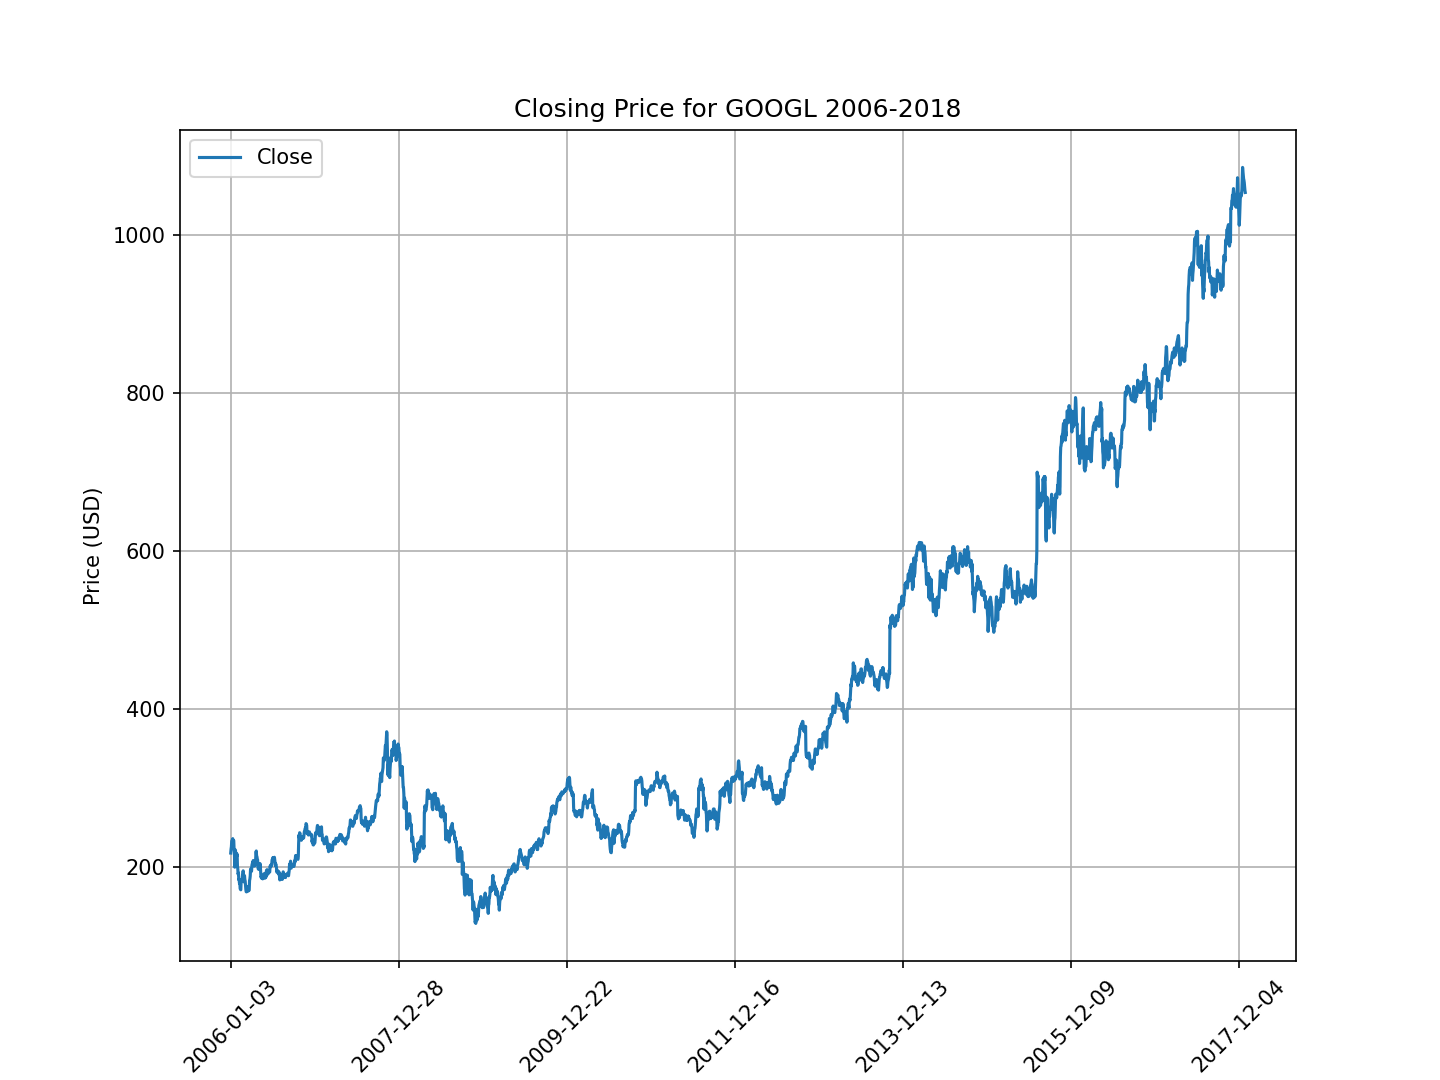

In [115]:
stock_df.plot(x='Date',y='Close',kind='line')
plt.title("Closing Price for GOOGL 2006-2018")
plt.xticks(rotation=45)
plt.ylabel("Price (USD)")
plt.grid()
plt.show()

In [90]:
stock = stock_df[['Close']]
min_val = float(stock.min(axis=0))
max_val = float(stock.max(axis=0))
stock_scaled = 2*((stock-min_val)/(max_val-min_val))-1
print(stock_scaled.head())
print(stock_scaled.tail())

      Close
0 -0.813896
1 -0.803418
2 -0.797122
3 -0.782042
4 -0.780745
         Close
3014  0.966055
3015  0.959759
3016  0.947942
3017  0.939053
3018  0.933720


In [93]:
def split_train_test(dataset,percentage,lookback):
    data_raw = dataset.to_numpy()
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data);
    train_size = int(percentage*data.shape[0])
    test_size = data.shape[0]-train_size
    
    x_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:]
    
    x_test = data[train_size:,:-1]
    y_test = data[train_size:,-1,:]
    
    return x_train, y_train, x_test, y_test, data

x_train,y_train,x_test,y_test, df = split_train_test(stock_scaled,80,20)

In [95]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
df = torch.from_numpy(df).type(torch.Tensor)

In [32]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 1000

In [33]:
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [34]:
model = LSTM(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)
criterion = nn.MSELoss()
lr = 0.01
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

In [35]:
model.train()
loss_curve = []

for epoch in tqdm(range(num_epochs)):
    y_hat = model(x_train)
    loss = criterion(y_hat,y_train)
    loss_curve += [loss.item()]
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  0%|                                                                                 | 1/1000 [00:00<04:12,  3.95it/s]

--- Iteration 1: training loss = 0.2976 ---


  0%|▏                                                                                | 2/1000 [00:00<04:23,  3.78it/s]

--- Iteration 2: training loss = 0.2711 ---


  0%|▏                                                                                | 3/1000 [00:00<04:16,  3.89it/s]

--- Iteration 3: training loss = 0.2557 ---


  0%|▎                                                                                | 4/1000 [00:01<04:13,  3.93it/s]

--- Iteration 4: training loss = 0.2455 ---


  0%|▍                                                                                | 5/1000 [00:01<04:09,  3.99it/s]

--- Iteration 5: training loss = 0.2335 ---


  1%|▍                                                                                | 6/1000 [00:01<04:05,  4.05it/s]

--- Iteration 6: training loss = 0.2191 ---


  1%|▌                                                                                | 7/1000 [00:01<04:01,  4.11it/s]

--- Iteration 7: training loss = 0.2012 ---


  1%|▋                                                                                | 8/1000 [00:02<04:05,  4.03it/s]

--- Iteration 8: training loss = 0.1873 ---


  1%|▋                                                                                | 9/1000 [00:02<04:08,  3.98it/s]

--- Iteration 9: training loss = 0.1738 ---


  1%|▊                                                                               | 10/1000 [00:02<04:10,  3.95it/s]

--- Iteration 10: training loss = 0.1634 ---


  1%|▉                                                                               | 11/1000 [00:02<04:13,  3.91it/s]

--- Iteration 11: training loss = 0.1503 ---


  1%|▉                                                                               | 12/1000 [00:03<04:02,  4.07it/s]

--- Iteration 12: training loss = 0.1417 ---


  1%|█                                                                               | 13/1000 [00:03<04:10,  3.95it/s]

--- Iteration 13: training loss = 0.1325 ---


  1%|█                                                                               | 14/1000 [00:03<04:07,  3.99it/s]

--- Iteration 14: training loss = 0.1236 ---


  2%|█▏                                                                              | 15/1000 [00:03<04:02,  4.06it/s]

--- Iteration 15: training loss = 0.1161 ---


  2%|█▎                                                                              | 16/1000 [00:04<04:04,  4.02it/s]

--- Iteration 16: training loss = 0.1098 ---


  2%|█▎                                                                              | 17/1000 [00:04<04:02,  4.06it/s]

--- Iteration 17: training loss = 0.1042 ---


  2%|█▍                                                                              | 18/1000 [00:04<04:11,  3.90it/s]

--- Iteration 18: training loss = 0.0990 ---


  2%|█▌                                                                              | 19/1000 [00:04<04:13,  3.87it/s]

--- Iteration 19: training loss = 0.0942 ---


  2%|█▌                                                                              | 20/1000 [00:05<04:11,  3.90it/s]

--- Iteration 20: training loss = 0.0899 ---


  2%|█▋                                                                              | 21/1000 [00:05<04:16,  3.81it/s]

--- Iteration 21: training loss = 0.0863 ---


  2%|█▊                                                                              | 22/1000 [00:05<04:12,  3.88it/s]

--- Iteration 22: training loss = 0.0831 ---


  2%|█▊                                                                              | 23/1000 [00:05<04:03,  4.01it/s]

--- Iteration 23: training loss = 0.0800 ---


  2%|█▉                                                                              | 24/1000 [00:06<04:01,  4.05it/s]

--- Iteration 24: training loss = 0.0772 ---


  2%|██                                                                              | 25/1000 [00:06<03:56,  4.12it/s]

--- Iteration 25: training loss = 0.0744 ---


  3%|██                                                                              | 26/1000 [00:06<04:04,  3.98it/s]

--- Iteration 26: training loss = 0.0718 ---


  3%|██▏                                                                             | 27/1000 [00:06<03:56,  4.11it/s]

--- Iteration 27: training loss = 0.0694 ---


  3%|██▏                                                                             | 28/1000 [00:07<04:04,  3.97it/s]

--- Iteration 28: training loss = 0.0671 ---


  3%|██▎                                                                             | 29/1000 [00:07<04:09,  3.90it/s]

--- Iteration 29: training loss = 0.0650 ---


  3%|██▍                                                                             | 30/1000 [00:07<04:06,  3.93it/s]

--- Iteration 30: training loss = 0.0630 ---


  3%|██▍                                                                             | 31/1000 [00:07<03:57,  4.07it/s]

--- Iteration 31: training loss = 0.0610 ---


  3%|██▌                                                                             | 32/1000 [00:08<04:01,  4.02it/s]

--- Iteration 32: training loss = 0.0592 ---


  3%|██▋                                                                             | 33/1000 [00:08<04:03,  3.96it/s]

--- Iteration 33: training loss = 0.0575 ---


  3%|██▋                                                                             | 34/1000 [00:08<03:58,  4.05it/s]

--- Iteration 34: training loss = 0.0559 ---


  4%|██▊                                                                             | 35/1000 [00:08<03:55,  4.09it/s]

--- Iteration 35: training loss = 0.0544 ---


  4%|██▉                                                                             | 36/1000 [00:09<03:56,  4.07it/s]

--- Iteration 36: training loss = 0.0530 ---


  4%|██▉                                                                             | 37/1000 [00:09<03:57,  4.06it/s]

--- Iteration 37: training loss = 0.0517 ---


  4%|███                                                                             | 38/1000 [00:09<03:56,  4.06it/s]

--- Iteration 38: training loss = 0.0504 ---


  4%|███                                                                             | 39/1000 [00:09<04:00,  4.00it/s]

--- Iteration 39: training loss = 0.0492 ---


  4%|███▏                                                                            | 40/1000 [00:10<04:01,  3.97it/s]

--- Iteration 40: training loss = 0.0481 ---


  4%|███▎                                                                            | 41/1000 [00:10<03:59,  4.01it/s]

--- Iteration 41: training loss = 0.0470 ---


  4%|███▎                                                                            | 42/1000 [00:10<04:00,  3.98it/s]

--- Iteration 42: training loss = 0.0459 ---


  4%|███▍                                                                            | 43/1000 [00:10<04:02,  3.95it/s]

--- Iteration 43: training loss = 0.0449 ---


  4%|███▌                                                                            | 44/1000 [00:11<03:56,  4.04it/s]

--- Iteration 44: training loss = 0.0439 ---


  4%|███▌                                                                            | 45/1000 [00:11<03:54,  4.07it/s]

--- Iteration 45: training loss = 0.0430 ---


  5%|███▋                                                                            | 46/1000 [00:11<03:58,  4.00it/s]

--- Iteration 46: training loss = 0.0421 ---


  5%|███▊                                                                            | 47/1000 [00:11<03:58,  4.00it/s]

--- Iteration 47: training loss = 0.0412 ---


  5%|███▊                                                                            | 48/1000 [00:12<04:01,  3.95it/s]

--- Iteration 48: training loss = 0.0404 ---


  5%|███▉                                                                            | 49/1000 [00:12<03:58,  3.99it/s]

--- Iteration 49: training loss = 0.0396 ---


  5%|████                                                                            | 50/1000 [00:12<04:00,  3.94it/s]

--- Iteration 50: training loss = 0.0388 ---


  5%|████                                                                            | 51/1000 [00:12<03:59,  3.96it/s]

--- Iteration 51: training loss = 0.0381 ---


  5%|████▏                                                                           | 52/1000 [00:13<03:54,  4.04it/s]

--- Iteration 52: training loss = 0.0374 ---


  5%|████▏                                                                           | 53/1000 [00:13<03:53,  4.06it/s]

--- Iteration 53: training loss = 0.0367 ---


  5%|████▎                                                                           | 54/1000 [00:13<04:00,  3.93it/s]

--- Iteration 54: training loss = 0.0360 ---


  6%|████▍                                                                           | 55/1000 [00:13<04:09,  3.79it/s]

--- Iteration 55: training loss = 0.0354 ---


  6%|████▍                                                                           | 56/1000 [00:14<04:23,  3.59it/s]

--- Iteration 56: training loss = 0.0348 ---


  6%|████▌                                                                           | 57/1000 [00:14<04:44,  3.32it/s]

--- Iteration 57: training loss = 0.0342 ---


  6%|████▋                                                                           | 58/1000 [00:14<05:01,  3.12it/s]

--- Iteration 58: training loss = 0.0336 ---


  6%|████▋                                                                           | 59/1000 [00:15<05:07,  3.06it/s]

--- Iteration 59: training loss = 0.0331 ---


  6%|████▊                                                                           | 60/1000 [00:15<05:12,  3.00it/s]

--- Iteration 60: training loss = 0.0325 ---


  6%|████▉                                                                           | 61/1000 [00:15<05:27,  2.87it/s]

--- Iteration 61: training loss = 0.0320 ---


  6%|████▉                                                                           | 62/1000 [00:16<05:34,  2.80it/s]

--- Iteration 62: training loss = 0.0315 ---


  6%|█████                                                                           | 63/1000 [00:16<05:49,  2.68it/s]

--- Iteration 63: training loss = 0.0310 ---


  6%|█████                                                                           | 64/1000 [00:17<05:38,  2.76it/s]

--- Iteration 64: training loss = 0.0306 ---


  6%|█████▏                                                                          | 65/1000 [00:17<05:36,  2.78it/s]

--- Iteration 65: training loss = 0.0301 ---


  7%|█████▎                                                                          | 66/1000 [00:17<05:23,  2.89it/s]

--- Iteration 66: training loss = 0.0297 ---


  7%|█████▎                                                                          | 67/1000 [00:18<05:16,  2.95it/s]

--- Iteration 67: training loss = 0.0292 ---


  7%|█████▍                                                                          | 68/1000 [00:18<05:11,  2.99it/s]

--- Iteration 68: training loss = 0.0288 ---


  7%|█████▌                                                                          | 69/1000 [00:18<05:09,  3.01it/s]

--- Iteration 69: training loss = 0.0284 ---


  7%|█████▌                                                                          | 70/1000 [00:19<05:18,  2.92it/s]

--- Iteration 70: training loss = 0.0280 ---


  7%|█████▋                                                                          | 71/1000 [00:19<05:20,  2.90it/s]

--- Iteration 71: training loss = 0.0276 ---


  7%|█████▊                                                                          | 72/1000 [00:19<05:20,  2.90it/s]

--- Iteration 72: training loss = 0.0272 ---


  7%|█████▊                                                                          | 73/1000 [00:20<05:11,  2.98it/s]

--- Iteration 73: training loss = 0.0269 ---


  7%|█████▉                                                                          | 74/1000 [00:20<05:10,  2.98it/s]

--- Iteration 74: training loss = 0.0265 ---


  8%|██████                                                                          | 75/1000 [00:20<05:04,  3.04it/s]

--- Iteration 75: training loss = 0.0262 ---


  8%|██████                                                                          | 76/1000 [00:21<04:59,  3.08it/s]

--- Iteration 76: training loss = 0.0258 ---


  8%|██████▏                                                                         | 77/1000 [00:21<04:53,  3.14it/s]

--- Iteration 77: training loss = 0.0255 ---


  8%|██████▏                                                                         | 78/1000 [00:21<04:49,  3.18it/s]

--- Iteration 78: training loss = 0.0252 ---


  8%|██████▎                                                                         | 79/1000 [00:21<04:51,  3.16it/s]

--- Iteration 79: training loss = 0.0249 ---


  8%|██████▍                                                                         | 80/1000 [00:22<04:58,  3.08it/s]

--- Iteration 80: training loss = 0.0246 ---


  8%|██████▍                                                                         | 81/1000 [00:22<04:52,  3.14it/s]

--- Iteration 81: training loss = 0.0243 ---


  8%|██████▌                                                                         | 82/1000 [00:22<04:45,  3.21it/s]

--- Iteration 82: training loss = 0.0240 ---


  8%|██████▋                                                                         | 83/1000 [00:23<04:42,  3.24it/s]

--- Iteration 83: training loss = 0.0237 ---


  8%|██████▋                                                                         | 84/1000 [00:23<04:49,  3.16it/s]

--- Iteration 84: training loss = 0.0234 ---


  8%|██████▊                                                                         | 85/1000 [00:23<04:46,  3.19it/s]

--- Iteration 85: training loss = 0.0232 ---


  9%|██████▉                                                                         | 86/1000 [00:24<04:40,  3.25it/s]

--- Iteration 86: training loss = 0.0229 ---


  9%|██████▉                                                                         | 87/1000 [00:24<04:34,  3.33it/s]

--- Iteration 87: training loss = 0.0227 ---


  9%|███████                                                                         | 88/1000 [00:24<04:37,  3.28it/s]

--- Iteration 88: training loss = 0.0224 ---


  9%|███████                                                                         | 89/1000 [00:25<04:37,  3.29it/s]

--- Iteration 89: training loss = 0.0222 ---


  9%|███████▏                                                                        | 90/1000 [00:25<04:31,  3.35it/s]

--- Iteration 90: training loss = 0.0219 ---


  9%|███████▎                                                                        | 91/1000 [00:25<04:29,  3.37it/s]

--- Iteration 91: training loss = 0.0217 ---


  9%|███████▎                                                                        | 92/1000 [00:25<04:37,  3.28it/s]

--- Iteration 92: training loss = 0.0215 ---


  9%|███████▍                                                                        | 93/1000 [00:26<04:47,  3.16it/s]

--- Iteration 93: training loss = 0.0212 ---


  9%|███████▌                                                                        | 94/1000 [00:26<04:42,  3.20it/s]

--- Iteration 94: training loss = 0.0210 ---


 10%|███████▌                                                                        | 95/1000 [00:26<04:35,  3.28it/s]

--- Iteration 95: training loss = 0.0208 ---


 10%|███████▋                                                                        | 96/1000 [00:27<04:40,  3.22it/s]

--- Iteration 96: training loss = 0.0206 ---


 10%|███████▊                                                                        | 97/1000 [00:27<05:02,  2.98it/s]

--- Iteration 97: training loss = 0.0204 ---


 10%|███████▊                                                                        | 98/1000 [00:27<05:02,  2.98it/s]

--- Iteration 98: training loss = 0.0202 ---


 10%|███████▉                                                                        | 99/1000 [00:28<05:41,  2.64it/s]

--- Iteration 99: training loss = 0.0200 ---


 10%|███████▉                                                                       | 100/1000 [00:28<05:52,  2.55it/s]

--- Iteration 100: training loss = 0.0198 ---


 10%|███████▉                                                                       | 101/1000 [00:29<05:31,  2.71it/s]

--- Iteration 101: training loss = 0.0196 ---


 10%|████████                                                                       | 102/1000 [00:29<05:18,  2.82it/s]

--- Iteration 102: training loss = 0.0194 ---


 10%|████████▏                                                                      | 103/1000 [00:29<05:07,  2.92it/s]

--- Iteration 103: training loss = 0.0192 ---


 10%|████████▏                                                                      | 104/1000 [00:30<04:59,  2.99it/s]

--- Iteration 104: training loss = 0.0191 ---


 10%|████████▎                                                                      | 105/1000 [00:30<05:04,  2.94it/s]

--- Iteration 105: training loss = 0.0189 ---


 11%|████████▎                                                                      | 106/1000 [00:30<04:56,  3.01it/s]

--- Iteration 106: training loss = 0.0187 ---


 11%|████████▍                                                                      | 107/1000 [00:31<04:46,  3.12it/s]

--- Iteration 107: training loss = 0.0185 ---


 11%|████████▌                                                                      | 108/1000 [00:31<04:44,  3.14it/s]

--- Iteration 108: training loss = 0.0184 ---


 11%|████████▌                                                                      | 109/1000 [00:31<04:42,  3.15it/s]

--- Iteration 109: training loss = 0.0182 ---


 11%|████████▋                                                                      | 110/1000 [00:32<04:49,  3.08it/s]

--- Iteration 110: training loss = 0.0181 ---


 11%|████████▊                                                                      | 111/1000 [00:32<04:43,  3.14it/s]

--- Iteration 111: training loss = 0.0179 ---


 11%|████████▊                                                                      | 112/1000 [00:32<04:40,  3.16it/s]

--- Iteration 112: training loss = 0.0177 ---


 11%|████████▉                                                                      | 113/1000 [00:32<04:37,  3.19it/s]

--- Iteration 113: training loss = 0.0176 ---


 11%|█████████                                                                      | 114/1000 [00:33<04:40,  3.16it/s]

--- Iteration 114: training loss = 0.0174 ---


 12%|█████████                                                                      | 115/1000 [00:33<04:36,  3.20it/s]

--- Iteration 115: training loss = 0.0173 ---


 12%|█████████▏                                                                     | 116/1000 [00:33<04:34,  3.22it/s]

--- Iteration 116: training loss = 0.0172 ---


 12%|█████████▏                                                                     | 117/1000 [00:34<04:35,  3.21it/s]

--- Iteration 117: training loss = 0.0170 ---


 12%|█████████▎                                                                     | 118/1000 [00:34<04:35,  3.21it/s]

--- Iteration 118: training loss = 0.0169 ---


 12%|█████████▍                                                                     | 119/1000 [00:34<04:29,  3.26it/s]

--- Iteration 119: training loss = 0.0167 ---


 12%|█████████▍                                                                     | 120/1000 [00:35<04:28,  3.27it/s]

--- Iteration 120: training loss = 0.0166 ---


 12%|█████████▌                                                                     | 121/1000 [00:35<04:27,  3.28it/s]

--- Iteration 121: training loss = 0.0165 ---


 12%|█████████▋                                                                     | 122/1000 [00:35<04:29,  3.25it/s]

--- Iteration 122: training loss = 0.0163 ---


 12%|█████████▋                                                                     | 123/1000 [00:36<04:36,  3.17it/s]

--- Iteration 123: training loss = 0.0162 ---


 12%|█████████▊                                                                     | 124/1000 [00:36<04:51,  3.00it/s]

--- Iteration 124: training loss = 0.0161 ---


 12%|█████████▉                                                                     | 125/1000 [00:36<04:43,  3.09it/s]

--- Iteration 125: training loss = 0.0160 ---


 13%|█████████▉                                                                     | 126/1000 [00:37<04:42,  3.09it/s]

--- Iteration 126: training loss = 0.0158 ---


 13%|██████████                                                                     | 127/1000 [00:37<04:32,  3.21it/s]

--- Iteration 127: training loss = 0.0157 ---


 13%|██████████                                                                     | 128/1000 [00:37<04:37,  3.14it/s]

--- Iteration 128: training loss = 0.0156 ---


 13%|██████████▏                                                                    | 129/1000 [00:38<04:38,  3.13it/s]

--- Iteration 129: training loss = 0.0155 ---


 13%|██████████▎                                                                    | 130/1000 [00:38<04:31,  3.21it/s]

--- Iteration 130: training loss = 0.0154 ---


 13%|██████████▎                                                                    | 131/1000 [00:38<04:28,  3.23it/s]

--- Iteration 131: training loss = 0.0153 ---


 13%|██████████▍                                                                    | 132/1000 [00:38<04:29,  3.22it/s]

--- Iteration 132: training loss = 0.0151 ---


 13%|██████████▌                                                                    | 133/1000 [00:39<04:29,  3.22it/s]

--- Iteration 133: training loss = 0.0150 ---


 13%|██████████▌                                                                    | 134/1000 [00:39<04:25,  3.26it/s]

--- Iteration 134: training loss = 0.0149 ---


 14%|██████████▋                                                                    | 135/1000 [00:39<04:26,  3.24it/s]

--- Iteration 135: training loss = 0.0148 ---


 14%|██████████▋                                                                    | 136/1000 [00:40<04:31,  3.19it/s]

--- Iteration 136: training loss = 0.0147 ---


 14%|██████████▊                                                                    | 137/1000 [00:40<04:38,  3.10it/s]

--- Iteration 137: training loss = 0.0146 ---


 14%|██████████▉                                                                    | 138/1000 [00:40<04:31,  3.18it/s]

--- Iteration 138: training loss = 0.0145 ---


 14%|██████████▉                                                                    | 139/1000 [00:41<04:33,  3.15it/s]

--- Iteration 139: training loss = 0.0144 ---


 14%|███████████                                                                    | 140/1000 [00:41<04:39,  3.08it/s]

--- Iteration 140: training loss = 0.0143 ---


 14%|███████████▏                                                                   | 141/1000 [00:41<04:36,  3.10it/s]

--- Iteration 141: training loss = 0.0142 ---


 14%|███████████▏                                                                   | 142/1000 [00:42<04:36,  3.10it/s]

--- Iteration 142: training loss = 0.0141 ---


 14%|███████████▎                                                                   | 143/1000 [00:42<04:31,  3.15it/s]

--- Iteration 143: training loss = 0.0140 ---


 14%|███████████▍                                                                   | 144/1000 [00:42<04:35,  3.10it/s]

--- Iteration 144: training loss = 0.0139 ---


 14%|███████████▍                                                                   | 145/1000 [00:43<04:38,  3.07it/s]

--- Iteration 145: training loss = 0.0138 ---


 15%|███████████▌                                                                   | 146/1000 [00:43<04:37,  3.08it/s]

--- Iteration 146: training loss = 0.0138 ---


 15%|███████████▌                                                                   | 147/1000 [00:43<04:31,  3.14it/s]

--- Iteration 147: training loss = 0.0137 ---


 15%|███████████▋                                                                   | 148/1000 [00:44<04:25,  3.21it/s]

--- Iteration 148: training loss = 0.0136 ---


 15%|███████████▊                                                                   | 149/1000 [00:44<04:20,  3.27it/s]

--- Iteration 149: training loss = 0.0135 ---


 15%|███████████▊                                                                   | 150/1000 [00:44<04:24,  3.21it/s]

--- Iteration 150: training loss = 0.0134 ---


 15%|███████████▉                                                                   | 151/1000 [00:44<04:27,  3.17it/s]

--- Iteration 151: training loss = 0.0133 ---


 15%|████████████                                                                   | 152/1000 [00:45<04:29,  3.15it/s]

--- Iteration 152: training loss = 0.0132 ---


 15%|████████████                                                                   | 153/1000 [00:45<04:25,  3.19it/s]

--- Iteration 153: training loss = 0.0131 ---


 15%|████████████▏                                                                  | 154/1000 [00:45<04:23,  3.22it/s]

--- Iteration 154: training loss = 0.0131 ---


 16%|████████████▏                                                                  | 155/1000 [00:46<04:20,  3.24it/s]

--- Iteration 155: training loss = 0.0130 ---


 16%|████████████▎                                                                  | 156/1000 [00:46<04:17,  3.28it/s]

--- Iteration 156: training loss = 0.0129 ---


 16%|████████████▍                                                                  | 157/1000 [00:46<04:16,  3.29it/s]

--- Iteration 157: training loss = 0.0128 ---


 16%|████████████▍                                                                  | 158/1000 [00:47<04:15,  3.29it/s]

--- Iteration 158: training loss = 0.0128 ---


 16%|████████████▌                                                                  | 159/1000 [00:47<04:20,  3.23it/s]

--- Iteration 159: training loss = 0.0127 ---


 16%|████████████▋                                                                  | 160/1000 [00:47<04:31,  3.10it/s]

--- Iteration 160: training loss = 0.0126 ---


 16%|████████████▋                                                                  | 161/1000 [00:48<04:26,  3.15it/s]

--- Iteration 161: training loss = 0.0125 ---


 16%|████████████▊                                                                  | 162/1000 [00:48<04:22,  3.19it/s]

--- Iteration 162: training loss = 0.0125 ---


 16%|████████████▉                                                                  | 163/1000 [00:48<04:17,  3.25it/s]

--- Iteration 163: training loss = 0.0124 ---


 16%|████████████▉                                                                  | 164/1000 [00:49<04:25,  3.15it/s]

--- Iteration 164: training loss = 0.0123 ---


 16%|█████████████                                                                  | 165/1000 [00:49<04:37,  3.01it/s]

--- Iteration 165: training loss = 0.0122 ---


 17%|█████████████                                                                  | 166/1000 [00:49<04:32,  3.06it/s]

--- Iteration 166: training loss = 0.0122 ---


 17%|█████████████▏                                                                 | 167/1000 [00:50<04:36,  3.02it/s]

--- Iteration 167: training loss = 0.0121 ---


 17%|█████████████▎                                                                 | 168/1000 [00:50<04:36,  3.01it/s]

--- Iteration 168: training loss = 0.0120 ---


 17%|█████████████▎                                                                 | 169/1000 [00:50<04:34,  3.03it/s]

--- Iteration 169: training loss = 0.0120 ---


 17%|█████████████▍                                                                 | 170/1000 [00:51<04:30,  3.07it/s]

--- Iteration 170: training loss = 0.0119 ---


 17%|█████████████▌                                                                 | 171/1000 [00:51<04:34,  3.02it/s]

--- Iteration 171: training loss = 0.0118 ---


 17%|█████████████▌                                                                 | 172/1000 [00:51<04:27,  3.10it/s]

--- Iteration 172: training loss = 0.0118 ---


 17%|█████████████▋                                                                 | 173/1000 [00:51<04:19,  3.19it/s]

--- Iteration 173: training loss = 0.0117 ---


 17%|█████████████▋                                                                 | 174/1000 [00:52<04:16,  3.22it/s]

--- Iteration 174: training loss = 0.0116 ---


 18%|█████████████▊                                                                 | 175/1000 [00:52<04:19,  3.18it/s]

--- Iteration 175: training loss = 0.0116 ---


 18%|█████████████▉                                                                 | 176/1000 [00:52<04:16,  3.21it/s]

--- Iteration 176: training loss = 0.0115 ---


 18%|█████████████▉                                                                 | 177/1000 [00:53<04:14,  3.24it/s]

--- Iteration 177: training loss = 0.0114 ---


 18%|██████████████                                                                 | 178/1000 [00:53<04:20,  3.16it/s]

--- Iteration 178: training loss = 0.0114 ---


 18%|██████████████▏                                                                | 179/1000 [00:53<04:19,  3.17it/s]

--- Iteration 179: training loss = 0.0113 ---


 18%|██████████████▏                                                                | 180/1000 [00:54<04:22,  3.12it/s]

--- Iteration 180: training loss = 0.0113 ---


 18%|██████████████▎                                                                | 181/1000 [00:54<04:21,  3.14it/s]

--- Iteration 181: training loss = 0.0112 ---


 18%|██████████████▍                                                                | 182/1000 [00:54<04:12,  3.24it/s]

--- Iteration 182: training loss = 0.0111 ---


 18%|██████████████▍                                                                | 183/1000 [00:55<04:18,  3.17it/s]

--- Iteration 183: training loss = 0.0111 ---


 18%|██████████████▌                                                                | 184/1000 [00:55<04:17,  3.17it/s]

--- Iteration 184: training loss = 0.0110 ---


 18%|██████████████▌                                                                | 185/1000 [00:55<04:16,  3.18it/s]

--- Iteration 185: training loss = 0.0110 ---


 19%|██████████████▋                                                                | 186/1000 [00:56<04:23,  3.09it/s]

--- Iteration 186: training loss = 0.0109 ---


 19%|██████████████▊                                                                | 187/1000 [00:56<04:15,  3.18it/s]

--- Iteration 187: training loss = 0.0109 ---


 19%|██████████████▊                                                                | 188/1000 [00:56<04:15,  3.18it/s]

--- Iteration 188: training loss = 0.0108 ---


 19%|██████████████▉                                                                | 189/1000 [00:57<04:21,  3.10it/s]

--- Iteration 189: training loss = 0.0108 ---


 19%|███████████████                                                                | 190/1000 [00:57<04:20,  3.11it/s]

--- Iteration 190: training loss = 0.0107 ---


 19%|███████████████                                                                | 191/1000 [00:57<04:20,  3.11it/s]

--- Iteration 191: training loss = 0.0106 ---


 19%|███████████████▏                                                               | 192/1000 [00:57<04:23,  3.07it/s]

--- Iteration 192: training loss = 0.0106 ---


 19%|███████████████▏                                                               | 193/1000 [00:58<04:15,  3.16it/s]

--- Iteration 193: training loss = 0.0105 ---


 19%|███████████████▎                                                               | 194/1000 [00:58<04:24,  3.05it/s]

--- Iteration 194: training loss = 0.0105 ---


 20%|███████████████▍                                                               | 195/1000 [00:58<04:22,  3.06it/s]

--- Iteration 195: training loss = 0.0104 ---


 20%|███████████████▍                                                               | 196/1000 [00:59<04:28,  2.99it/s]

--- Iteration 196: training loss = 0.0104 ---


 20%|███████████████▌                                                               | 197/1000 [00:59<04:33,  2.94it/s]

--- Iteration 197: training loss = 0.0103 ---


 20%|███████████████▋                                                               | 198/1000 [01:00<04:33,  2.93it/s]

--- Iteration 198: training loss = 0.0103 ---


 20%|███████████████▋                                                               | 199/1000 [01:00<04:29,  2.97it/s]

--- Iteration 199: training loss = 0.0102 ---


 20%|███████████████▊                                                               | 200/1000 [01:00<04:21,  3.06it/s]

--- Iteration 200: training loss = 0.0102 ---


 20%|███████████████▉                                                               | 201/1000 [01:00<04:15,  3.13it/s]

--- Iteration 201: training loss = 0.0101 ---


 20%|███████████████▉                                                               | 202/1000 [01:01<04:18,  3.09it/s]

--- Iteration 202: training loss = 0.0101 ---


 20%|████████████████                                                               | 203/1000 [01:01<04:15,  3.11it/s]

--- Iteration 203: training loss = 0.0100 ---


 20%|████████████████                                                               | 204/1000 [01:01<04:18,  3.08it/s]

--- Iteration 204: training loss = 0.0100 ---


 20%|████████████████▏                                                              | 205/1000 [01:02<04:16,  3.10it/s]

--- Iteration 205: training loss = 0.0100 ---


 21%|████████████████▎                                                              | 206/1000 [01:02<04:18,  3.07it/s]

--- Iteration 206: training loss = 0.0099 ---


 21%|████████████████▎                                                              | 207/1000 [01:02<04:15,  3.10it/s]

--- Iteration 207: training loss = 0.0099 ---


 21%|████████████████▍                                                              | 208/1000 [01:03<04:10,  3.16it/s]

--- Iteration 208: training loss = 0.0098 ---


 21%|████████████████▌                                                              | 209/1000 [01:03<04:09,  3.17it/s]

--- Iteration 209: training loss = 0.0098 ---


 21%|████████████████▌                                                              | 210/1000 [01:03<04:02,  3.26it/s]

--- Iteration 210: training loss = 0.0097 ---


 21%|████████████████▋                                                              | 211/1000 [01:04<04:00,  3.28it/s]

--- Iteration 211: training loss = 0.0097 ---


 21%|████████████████▋                                                              | 212/1000 [01:04<04:00,  3.27it/s]

--- Iteration 212: training loss = 0.0096 ---


 21%|████████████████▊                                                              | 213/1000 [01:04<03:57,  3.31it/s]

--- Iteration 213: training loss = 0.0096 ---


 21%|████████████████▉                                                              | 214/1000 [01:04<03:55,  3.34it/s]

--- Iteration 214: training loss = 0.0096 ---


 22%|████████████████▉                                                              | 215/1000 [01:05<03:58,  3.29it/s]

--- Iteration 215: training loss = 0.0095 ---


 22%|█████████████████                                                              | 216/1000 [01:05<04:07,  3.17it/s]

--- Iteration 216: training loss = 0.0095 ---


 22%|█████████████████▏                                                             | 217/1000 [01:05<04:04,  3.20it/s]

--- Iteration 217: training loss = 0.0094 ---


 22%|█████████████████▏                                                             | 218/1000 [01:06<04:01,  3.23it/s]

--- Iteration 218: training loss = 0.0094 ---


 22%|█████████████████▎                                                             | 219/1000 [01:06<04:12,  3.09it/s]

--- Iteration 219: training loss = 0.0094 ---


 22%|█████████████████▍                                                             | 220/1000 [01:06<04:10,  3.12it/s]

--- Iteration 220: training loss = 0.0093 ---


 22%|█████████████████▍                                                             | 221/1000 [01:07<04:12,  3.08it/s]

--- Iteration 221: training loss = 0.0093 ---


 22%|█████████████████▌                                                             | 222/1000 [01:07<04:12,  3.08it/s]

--- Iteration 222: training loss = 0.0092 ---


 22%|█████████████████▌                                                             | 223/1000 [01:07<04:16,  3.03it/s]

--- Iteration 223: training loss = 0.0092 ---


 22%|█████████████████▋                                                             | 224/1000 [01:08<04:12,  3.07it/s]

--- Iteration 224: training loss = 0.0092 ---


 22%|█████████████████▊                                                             | 225/1000 [01:08<04:14,  3.05it/s]

--- Iteration 225: training loss = 0.0091 ---


 23%|█████████████████▊                                                             | 226/1000 [01:08<04:15,  3.03it/s]

--- Iteration 226: training loss = 0.0091 ---


 23%|█████████████████▉                                                             | 227/1000 [01:09<04:23,  2.94it/s]

--- Iteration 227: training loss = 0.0090 ---


 23%|██████████████████                                                             | 228/1000 [01:09<04:39,  2.76it/s]

--- Iteration 228: training loss = 0.0090 ---


 23%|██████████████████                                                             | 229/1000 [01:10<04:48,  2.67it/s]

--- Iteration 229: training loss = 0.0090 ---


 23%|██████████████████▏                                                            | 230/1000 [01:10<04:45,  2.70it/s]

--- Iteration 230: training loss = 0.0089 ---


 23%|██████████████████▏                                                            | 231/1000 [01:10<04:48,  2.67it/s]

--- Iteration 231: training loss = 0.0089 ---


 23%|██████████████████▎                                                            | 232/1000 [01:11<04:47,  2.67it/s]

--- Iteration 232: training loss = 0.0089 ---


 23%|██████████████████▍                                                            | 233/1000 [01:11<04:42,  2.71it/s]

--- Iteration 233: training loss = 0.0088 ---


 23%|██████████████████▍                                                            | 234/1000 [01:11<04:34,  2.79it/s]

--- Iteration 234: training loss = 0.0088 ---


 24%|██████████████████▌                                                            | 235/1000 [01:12<04:23,  2.90it/s]

--- Iteration 235: training loss = 0.0088 ---


 24%|██████████████████▋                                                            | 236/1000 [01:12<04:21,  2.92it/s]

--- Iteration 236: training loss = 0.0087 ---


 24%|██████████████████▋                                                            | 237/1000 [01:12<04:12,  3.03it/s]

--- Iteration 237: training loss = 0.0087 ---


 24%|██████████████████▊                                                            | 238/1000 [01:13<04:05,  3.10it/s]

--- Iteration 238: training loss = 0.0086 ---


 24%|██████████████████▉                                                            | 239/1000 [01:13<04:08,  3.07it/s]

--- Iteration 239: training loss = 0.0086 ---


 24%|██████████████████▉                                                            | 240/1000 [01:13<04:09,  3.04it/s]

--- Iteration 240: training loss = 0.0086 ---


 24%|███████████████████                                                            | 241/1000 [01:14<04:08,  3.05it/s]

--- Iteration 241: training loss = 0.0085 ---


 24%|███████████████████                                                            | 242/1000 [01:14<04:00,  3.15it/s]

--- Iteration 242: training loss = 0.0085 ---


 24%|███████████████████▏                                                           | 243/1000 [01:14<04:04,  3.10it/s]

--- Iteration 243: training loss = 0.0085 ---


 24%|███████████████████▎                                                           | 244/1000 [01:15<04:03,  3.10it/s]

--- Iteration 244: training loss = 0.0084 ---


 24%|███████████████████▎                                                           | 245/1000 [01:15<03:59,  3.15it/s]

--- Iteration 245: training loss = 0.0084 ---


 25%|███████████████████▍                                                           | 246/1000 [01:15<03:58,  3.16it/s]

--- Iteration 246: training loss = 0.0084 ---


 25%|███████████████████▌                                                           | 247/1000 [01:16<03:59,  3.14it/s]

--- Iteration 247: training loss = 0.0084 ---


 25%|███████████████████▌                                                           | 248/1000 [01:16<04:03,  3.09it/s]

--- Iteration 248: training loss = 0.0083 ---


 25%|███████████████████▋                                                           | 249/1000 [01:16<04:09,  3.01it/s]

--- Iteration 249: training loss = 0.0083 ---


 25%|███████████████████▊                                                           | 250/1000 [01:17<04:10,  3.00it/s]

--- Iteration 250: training loss = 0.0083 ---


 25%|███████████████████▊                                                           | 251/1000 [01:17<04:02,  3.08it/s]

--- Iteration 251: training loss = 0.0082 ---


 25%|███████████████████▉                                                           | 252/1000 [01:17<04:11,  2.97it/s]

--- Iteration 252: training loss = 0.0082 ---


 25%|███████████████████▉                                                           | 253/1000 [01:18<04:03,  3.06it/s]

--- Iteration 253: training loss = 0.0082 ---


 25%|████████████████████                                                           | 254/1000 [01:18<03:58,  3.13it/s]

--- Iteration 254: training loss = 0.0081 ---


 26%|████████████████████▏                                                          | 255/1000 [01:18<03:56,  3.15it/s]

--- Iteration 255: training loss = 0.0081 ---


 26%|████████████████████▏                                                          | 256/1000 [01:19<04:06,  3.01it/s]

--- Iteration 256: training loss = 0.0081 ---


 26%|████████████████████▎                                                          | 257/1000 [01:19<03:58,  3.12it/s]

--- Iteration 257: training loss = 0.0080 ---


 26%|████████████████████▍                                                          | 258/1000 [01:19<03:54,  3.17it/s]

--- Iteration 258: training loss = 0.0080 ---


 26%|████████████████████▍                                                          | 259/1000 [01:19<04:04,  3.03it/s]

--- Iteration 259: training loss = 0.0080 ---


 26%|████████████████████▌                                                          | 260/1000 [01:20<04:09,  2.96it/s]

--- Iteration 260: training loss = 0.0080 ---


 26%|████████████████████▌                                                          | 261/1000 [01:20<04:16,  2.88it/s]

--- Iteration 261: training loss = 0.0079 ---


 26%|████████████████████▋                                                          | 262/1000 [01:21<04:19,  2.85it/s]

--- Iteration 262: training loss = 0.0079 ---


 26%|████████████████████▊                                                          | 263/1000 [01:21<04:19,  2.84it/s]

--- Iteration 263: training loss = 0.0079 ---


 26%|████████████████████▊                                                          | 264/1000 [01:21<04:46,  2.57it/s]

--- Iteration 264: training loss = 0.0078 ---


 26%|████████████████████▉                                                          | 265/1000 [01:22<04:55,  2.48it/s]

--- Iteration 265: training loss = 0.0078 ---


 27%|█████████████████████                                                          | 266/1000 [01:22<05:06,  2.39it/s]

--- Iteration 266: training loss = 0.0078 ---


 27%|█████████████████████                                                          | 267/1000 [01:23<05:03,  2.41it/s]

--- Iteration 267: training loss = 0.0078 ---


 27%|█████████████████████▏                                                         | 268/1000 [01:23<05:10,  2.36it/s]

--- Iteration 268: training loss = 0.0077 ---


 27%|█████████████████████▎                                                         | 269/1000 [01:24<05:05,  2.39it/s]

--- Iteration 269: training loss = 0.0077 ---


 27%|█████████████████████▎                                                         | 270/1000 [01:24<05:08,  2.36it/s]

--- Iteration 270: training loss = 0.0077 ---


 27%|█████████████████████▍                                                         | 271/1000 [01:24<05:06,  2.38it/s]

--- Iteration 271: training loss = 0.0077 ---


 27%|█████████████████████▍                                                         | 272/1000 [01:25<05:04,  2.39it/s]

--- Iteration 272: training loss = 0.0076 ---


 27%|█████████████████████▌                                                         | 273/1000 [01:25<05:10,  2.34it/s]

--- Iteration 273: training loss = 0.0076 ---


 27%|█████████████████████▋                                                         | 274/1000 [01:26<05:10,  2.33it/s]

--- Iteration 274: training loss = 0.0076 ---


 28%|█████████████████████▋                                                         | 275/1000 [01:26<05:23,  2.24it/s]

--- Iteration 275: training loss = 0.0076 ---


 28%|█████████████████████▊                                                         | 276/1000 [01:27<05:31,  2.18it/s]

--- Iteration 276: training loss = 0.0075 ---


 28%|█████████████████████▉                                                         | 277/1000 [01:27<05:30,  2.19it/s]

--- Iteration 277: training loss = 0.0075 ---


 28%|█████████████████████▉                                                         | 278/1000 [01:28<05:28,  2.20it/s]

--- Iteration 278: training loss = 0.0075 ---


 28%|██████████████████████                                                         | 279/1000 [01:28<05:21,  2.24it/s]

--- Iteration 279: training loss = 0.0075 ---


 28%|██████████████████████                                                         | 280/1000 [01:28<05:12,  2.31it/s]

--- Iteration 280: training loss = 0.0074 ---


 28%|██████████████████████▏                                                        | 281/1000 [01:29<04:56,  2.43it/s]

--- Iteration 281: training loss = 0.0074 ---


 28%|██████████████████████▎                                                        | 282/1000 [01:29<05:05,  2.35it/s]

--- Iteration 282: training loss = 0.0074 ---


 28%|██████████████████████▎                                                        | 283/1000 [01:30<05:04,  2.35it/s]

--- Iteration 283: training loss = 0.0074 ---


 28%|██████████████████████▍                                                        | 284/1000 [01:30<05:08,  2.32it/s]

--- Iteration 284: training loss = 0.0073 ---


 28%|██████████████████████▌                                                        | 285/1000 [01:31<05:11,  2.29it/s]

--- Iteration 285: training loss = 0.0073 ---


 29%|██████████████████████▌                                                        | 286/1000 [01:31<05:06,  2.33it/s]

--- Iteration 286: training loss = 0.0073 ---


 29%|██████████████████████▋                                                        | 287/1000 [01:31<04:54,  2.42it/s]

--- Iteration 287: training loss = 0.0073 ---


 29%|██████████████████████▊                                                        | 288/1000 [01:32<05:01,  2.36it/s]

--- Iteration 288: training loss = 0.0072 ---


 29%|██████████████████████▊                                                        | 289/1000 [01:32<04:59,  2.38it/s]

--- Iteration 289: training loss = 0.0072 ---


 29%|██████████████████████▉                                                        | 290/1000 [01:33<04:52,  2.42it/s]

--- Iteration 290: training loss = 0.0072 ---


 29%|██████████████████████▉                                                        | 291/1000 [01:33<04:50,  2.44it/s]

--- Iteration 291: training loss = 0.0072 ---


 29%|███████████████████████                                                        | 292/1000 [01:33<04:43,  2.50it/s]

--- Iteration 292: training loss = 0.0071 ---


 29%|███████████████████████▏                                                       | 293/1000 [01:34<04:43,  2.49it/s]

--- Iteration 293: training loss = 0.0071 ---


 29%|███████████████████████▏                                                       | 294/1000 [01:34<04:41,  2.51it/s]

--- Iteration 294: training loss = 0.0071 ---


 30%|███████████████████████▎                                                       | 295/1000 [01:35<04:50,  2.42it/s]

--- Iteration 295: training loss = 0.0071 ---


 30%|███████████████████████▍                                                       | 296/1000 [01:35<04:50,  2.42it/s]

--- Iteration 296: training loss = 0.0071 ---


 30%|███████████████████████▍                                                       | 297/1000 [01:35<04:57,  2.37it/s]

--- Iteration 297: training loss = 0.0070 ---


 30%|███████████████████████▌                                                       | 298/1000 [01:36<04:52,  2.40it/s]

--- Iteration 298: training loss = 0.0070 ---


 30%|███████████████████████▌                                                       | 299/1000 [01:36<04:49,  2.42it/s]

--- Iteration 299: training loss = 0.0070 ---


 30%|███████████████████████▋                                                       | 300/1000 [01:37<04:45,  2.45it/s]

--- Iteration 300: training loss = 0.0070 ---


 30%|███████████████████████▊                                                       | 301/1000 [01:37<04:39,  2.50it/s]

--- Iteration 301: training loss = 0.0069 ---


 30%|███████████████████████▊                                                       | 302/1000 [01:37<04:48,  2.42it/s]

--- Iteration 302: training loss = 0.0069 ---


 30%|███████████████████████▉                                                       | 303/1000 [01:38<04:44,  2.45it/s]

--- Iteration 303: training loss = 0.0069 ---


 30%|████████████████████████                                                       | 304/1000 [01:38<04:42,  2.46it/s]

--- Iteration 304: training loss = 0.0069 ---


 30%|████████████████████████                                                       | 305/1000 [01:39<04:37,  2.51it/s]

--- Iteration 305: training loss = 0.0069 ---


 31%|████████████████████████▏                                                      | 306/1000 [01:39<04:42,  2.45it/s]

--- Iteration 306: training loss = 0.0068 ---


 31%|████████████████████████▎                                                      | 307/1000 [01:39<04:44,  2.44it/s]

--- Iteration 307: training loss = 0.0068 ---


 31%|████████████████████████▎                                                      | 308/1000 [01:40<04:46,  2.42it/s]

--- Iteration 308: training loss = 0.0068 ---


 31%|████████████████████████▍                                                      | 309/1000 [01:40<04:46,  2.41it/s]

--- Iteration 309: training loss = 0.0068 ---


 31%|████████████████████████▍                                                      | 310/1000 [01:41<04:45,  2.42it/s]

--- Iteration 310: training loss = 0.0068 ---


 31%|████████████████████████▌                                                      | 311/1000 [01:41<04:33,  2.52it/s]

--- Iteration 311: training loss = 0.0067 ---


 31%|████████████████████████▋                                                      | 312/1000 [01:41<04:32,  2.53it/s]

--- Iteration 312: training loss = 0.0067 ---


 31%|████████████████████████▋                                                      | 313/1000 [01:42<04:25,  2.58it/s]

--- Iteration 313: training loss = 0.0067 ---


 31%|████████████████████████▊                                                      | 314/1000 [01:42<04:31,  2.53it/s]

--- Iteration 314: training loss = 0.0067 ---


 32%|████████████████████████▉                                                      | 315/1000 [01:43<04:22,  2.61it/s]

--- Iteration 315: training loss = 0.0067 ---


 32%|████████████████████████▉                                                      | 316/1000 [01:43<04:05,  2.79it/s]

--- Iteration 316: training loss = 0.0066 ---


 32%|█████████████████████████                                                      | 317/1000 [01:43<03:52,  2.94it/s]

--- Iteration 317: training loss = 0.0066 ---


 32%|█████████████████████████                                                      | 318/1000 [01:44<03:50,  2.96it/s]

--- Iteration 318: training loss = 0.0066 ---


 32%|█████████████████████████▏                                                     | 319/1000 [01:44<03:43,  3.04it/s]

--- Iteration 319: training loss = 0.0066 ---


 32%|█████████████████████████▎                                                     | 320/1000 [01:44<03:40,  3.08it/s]

--- Iteration 320: training loss = 0.0066 ---


 32%|█████████████████████████▎                                                     | 321/1000 [01:44<03:35,  3.14it/s]

--- Iteration 321: training loss = 0.0065 ---


 32%|█████████████████████████▍                                                     | 322/1000 [01:45<03:32,  3.19it/s]

--- Iteration 322: training loss = 0.0065 ---


 32%|█████████████████████████▌                                                     | 323/1000 [01:45<03:29,  3.22it/s]

--- Iteration 323: training loss = 0.0065 ---


 32%|█████████████████████████▌                                                     | 324/1000 [01:45<03:30,  3.21it/s]

--- Iteration 324: training loss = 0.0065 ---


 32%|█████████████████████████▋                                                     | 325/1000 [01:46<03:29,  3.23it/s]

--- Iteration 325: training loss = 0.0065 ---


 33%|█████████████████████████▊                                                     | 326/1000 [01:46<03:29,  3.21it/s]

--- Iteration 326: training loss = 0.0064 ---


 33%|█████████████████████████▊                                                     | 327/1000 [01:46<03:31,  3.18it/s]

--- Iteration 327: training loss = 0.0064 ---


 33%|█████████████████████████▉                                                     | 328/1000 [01:47<03:33,  3.15it/s]

--- Iteration 328: training loss = 0.0064 ---


 33%|█████████████████████████▉                                                     | 329/1000 [01:47<03:33,  3.14it/s]

--- Iteration 329: training loss = 0.0064 ---


 33%|██████████████████████████                                                     | 330/1000 [01:47<03:24,  3.27it/s]

--- Iteration 330: training loss = 0.0064 ---


 33%|██████████████████████████▏                                                    | 331/1000 [01:48<03:30,  3.18it/s]

--- Iteration 331: training loss = 0.0064 ---


 33%|██████████████████████████▏                                                    | 332/1000 [01:48<03:29,  3.19it/s]

--- Iteration 332: training loss = 0.0063 ---


 33%|██████████████████████████▎                                                    | 333/1000 [01:48<03:27,  3.22it/s]

--- Iteration 333: training loss = 0.0063 ---


 33%|██████████████████████████▍                                                    | 334/1000 [01:49<03:27,  3.21it/s]

--- Iteration 334: training loss = 0.0063 ---


 34%|██████████████████████████▍                                                    | 335/1000 [01:49<03:21,  3.30it/s]

--- Iteration 335: training loss = 0.0063 ---


 34%|██████████████████████████▌                                                    | 336/1000 [01:49<03:27,  3.20it/s]

--- Iteration 336: training loss = 0.0063 ---


 34%|██████████████████████████▌                                                    | 337/1000 [01:49<03:27,  3.20it/s]

--- Iteration 337: training loss = 0.0063 ---


 34%|██████████████████████████▋                                                    | 338/1000 [01:50<03:25,  3.23it/s]

--- Iteration 338: training loss = 0.0062 ---


 34%|██████████████████████████▊                                                    | 339/1000 [01:50<03:23,  3.25it/s]

--- Iteration 339: training loss = 0.0062 ---


 34%|██████████████████████████▊                                                    | 340/1000 [01:50<03:28,  3.16it/s]

--- Iteration 340: training loss = 0.0062 ---


 34%|██████████████████████████▉                                                    | 341/1000 [01:51<03:29,  3.15it/s]

--- Iteration 341: training loss = 0.0062 ---


 34%|███████████████████████████                                                    | 342/1000 [01:51<03:36,  3.04it/s]

--- Iteration 342: training loss = 0.0062 ---


 34%|███████████████████████████                                                    | 343/1000 [01:51<03:34,  3.06it/s]

--- Iteration 343: training loss = 0.0062 ---


 34%|███████████████████████████▏                                                   | 344/1000 [01:52<03:30,  3.12it/s]

--- Iteration 344: training loss = 0.0061 ---


 34%|███████████████████████████▎                                                   | 345/1000 [01:52<03:28,  3.14it/s]

--- Iteration 345: training loss = 0.0061 ---


 35%|███████████████████████████▎                                                   | 346/1000 [01:52<03:29,  3.12it/s]

--- Iteration 346: training loss = 0.0061 ---


 35%|███████████████████████████▍                                                   | 347/1000 [01:53<03:26,  3.16it/s]

--- Iteration 347: training loss = 0.0061 ---


 35%|███████████████████████████▍                                                   | 348/1000 [01:53<03:23,  3.21it/s]

--- Iteration 348: training loss = 0.0061 ---


 35%|███████████████████████████▌                                                   | 349/1000 [01:53<03:20,  3.25it/s]

--- Iteration 349: training loss = 0.0061 ---


 35%|███████████████████████████▋                                                   | 350/1000 [01:54<03:24,  3.18it/s]

--- Iteration 350: training loss = 0.0060 ---


 35%|███████████████████████████▋                                                   | 351/1000 [01:54<03:18,  3.27it/s]

--- Iteration 351: training loss = 0.0060 ---


 35%|███████████████████████████▊                                                   | 352/1000 [01:54<03:19,  3.24it/s]

--- Iteration 352: training loss = 0.0060 ---


 35%|███████████████████████████▉                                                   | 353/1000 [01:55<03:20,  3.22it/s]

--- Iteration 353: training loss = 0.0060 ---


 35%|███████████████████████████▉                                                   | 354/1000 [01:55<03:23,  3.18it/s]

--- Iteration 354: training loss = 0.0060 ---


 36%|████████████████████████████                                                   | 355/1000 [01:55<03:26,  3.12it/s]

--- Iteration 355: training loss = 0.0060 ---


 36%|████████████████████████████                                                   | 356/1000 [01:55<03:25,  3.14it/s]

--- Iteration 356: training loss = 0.0059 ---


 36%|████████████████████████████▏                                                  | 357/1000 [01:56<03:16,  3.28it/s]

--- Iteration 357: training loss = 0.0059 ---


 36%|████████████████████████████▎                                                  | 358/1000 [01:56<03:15,  3.28it/s]

--- Iteration 358: training loss = 0.0059 ---


 36%|████████████████████████████▎                                                  | 359/1000 [01:56<03:22,  3.16it/s]

--- Iteration 359: training loss = 0.0059 ---


 36%|████████████████████████████▍                                                  | 360/1000 [01:57<03:20,  3.20it/s]

--- Iteration 360: training loss = 0.0059 ---


 36%|████████████████████████████▌                                                  | 361/1000 [01:57<03:16,  3.26it/s]

--- Iteration 361: training loss = 0.0059 ---


 36%|████████████████████████████▌                                                  | 362/1000 [01:57<03:19,  3.20it/s]

--- Iteration 362: training loss = 0.0059 ---


 36%|████████████████████████████▋                                                  | 363/1000 [01:58<03:17,  3.23it/s]

--- Iteration 363: training loss = 0.0058 ---


 36%|████████████████████████████▊                                                  | 364/1000 [01:58<03:23,  3.12it/s]

--- Iteration 364: training loss = 0.0058 ---


 36%|████████████████████████████▊                                                  | 365/1000 [01:58<03:25,  3.08it/s]

--- Iteration 365: training loss = 0.0058 ---


 37%|████████████████████████████▉                                                  | 366/1000 [01:59<03:25,  3.08it/s]

--- Iteration 366: training loss = 0.0058 ---


 37%|████████████████████████████▉                                                  | 367/1000 [01:59<03:19,  3.17it/s]

--- Iteration 367: training loss = 0.0058 ---


 37%|█████████████████████████████                                                  | 368/1000 [01:59<03:19,  3.18it/s]

--- Iteration 368: training loss = 0.0058 ---


 37%|█████████████████████████████▏                                                 | 369/1000 [02:00<03:24,  3.09it/s]

--- Iteration 369: training loss = 0.0057 ---


 37%|█████████████████████████████▏                                                 | 370/1000 [02:00<03:22,  3.12it/s]

--- Iteration 370: training loss = 0.0057 ---


 37%|█████████████████████████████▎                                                 | 371/1000 [02:00<03:24,  3.08it/s]

--- Iteration 371: training loss = 0.0057 ---


 37%|█████████████████████████████▍                                                 | 372/1000 [02:01<03:19,  3.14it/s]

--- Iteration 372: training loss = 0.0057 ---


 37%|█████████████████████████████▍                                                 | 373/1000 [02:01<03:14,  3.22it/s]

--- Iteration 373: training loss = 0.0057 ---


 37%|█████████████████████████████▌                                                 | 374/1000 [02:01<03:22,  3.09it/s]

--- Iteration 374: training loss = 0.0057 ---


 38%|█████████████████████████████▋                                                 | 375/1000 [02:01<03:20,  3.12it/s]

--- Iteration 375: training loss = 0.0057 ---


 38%|█████████████████████████████▋                                                 | 376/1000 [02:02<03:18,  3.14it/s]

--- Iteration 376: training loss = 0.0056 ---


 38%|█████████████████████████████▊                                                 | 377/1000 [02:02<03:17,  3.16it/s]

--- Iteration 377: training loss = 0.0056 ---


 38%|█████████████████████████████▊                                                 | 378/1000 [02:02<03:16,  3.17it/s]

--- Iteration 378: training loss = 0.0056 ---


 38%|█████████████████████████████▉                                                 | 379/1000 [02:03<03:10,  3.26it/s]

--- Iteration 379: training loss = 0.0056 ---


 38%|██████████████████████████████                                                 | 380/1000 [02:03<03:15,  3.18it/s]

--- Iteration 380: training loss = 0.0056 ---


 38%|██████████████████████████████                                                 | 381/1000 [02:03<03:14,  3.18it/s]

--- Iteration 381: training loss = 0.0056 ---


 38%|██████████████████████████████▏                                                | 382/1000 [02:04<03:11,  3.22it/s]

--- Iteration 382: training loss = 0.0056 ---


 38%|██████████████████████████████▎                                                | 383/1000 [02:04<03:12,  3.20it/s]

--- Iteration 383: training loss = 0.0056 ---


 38%|██████████████████████████████▎                                                | 384/1000 [02:04<03:10,  3.23it/s]

--- Iteration 384: training loss = 0.0055 ---


 38%|██████████████████████████████▍                                                | 385/1000 [02:05<03:09,  3.25it/s]

--- Iteration 385: training loss = 0.0055 ---


 39%|██████████████████████████████▍                                                | 386/1000 [02:05<03:12,  3.20it/s]

--- Iteration 386: training loss = 0.0055 ---


 39%|██████████████████████████████▌                                                | 387/1000 [02:05<03:12,  3.19it/s]

--- Iteration 387: training loss = 0.0055 ---


 39%|██████████████████████████████▋                                                | 388/1000 [02:06<03:13,  3.16it/s]

--- Iteration 388: training loss = 0.0055 ---


 39%|██████████████████████████████▋                                                | 389/1000 [02:06<03:09,  3.23it/s]

--- Iteration 389: training loss = 0.0055 ---


 39%|██████████████████████████████▊                                                | 390/1000 [02:06<03:07,  3.25it/s]

--- Iteration 390: training loss = 0.0055 ---


 39%|██████████████████████████████▉                                                | 391/1000 [02:06<03:08,  3.23it/s]

--- Iteration 391: training loss = 0.0054 ---


 39%|██████████████████████████████▉                                                | 392/1000 [02:07<03:05,  3.28it/s]

--- Iteration 392: training loss = 0.0054 ---


 39%|███████████████████████████████                                                | 393/1000 [02:07<03:10,  3.19it/s]

--- Iteration 393: training loss = 0.0054 ---


 39%|███████████████████████████████▏                                               | 394/1000 [02:07<03:17,  3.07it/s]

--- Iteration 394: training loss = 0.0054 ---


 40%|███████████████████████████████▏                                               | 395/1000 [02:08<03:08,  3.20it/s]

--- Iteration 395: training loss = 0.0054 ---


 40%|███████████████████████████████▎                                               | 396/1000 [02:08<03:15,  3.09it/s]

--- Iteration 396: training loss = 0.0054 ---


 40%|███████████████████████████████▎                                               | 397/1000 [02:08<03:15,  3.09it/s]

--- Iteration 397: training loss = 0.0054 ---


 40%|███████████████████████████████▍                                               | 398/1000 [02:09<03:09,  3.17it/s]

--- Iteration 398: training loss = 0.0054 ---


 40%|███████████████████████████████▌                                               | 399/1000 [02:09<03:12,  3.12it/s]

--- Iteration 399: training loss = 0.0053 ---


 40%|███████████████████████████████▌                                               | 400/1000 [02:09<03:09,  3.17it/s]

--- Iteration 400: training loss = 0.0053 ---


 40%|███████████████████████████████▋                                               | 401/1000 [02:10<03:08,  3.18it/s]

--- Iteration 401: training loss = 0.0053 ---


 40%|███████████████████████████████▊                                               | 402/1000 [02:10<03:06,  3.21it/s]

--- Iteration 402: training loss = 0.0053 ---


 40%|███████████████████████████████▊                                               | 403/1000 [02:10<03:05,  3.21it/s]

--- Iteration 403: training loss = 0.0053 ---


 40%|███████████████████████████████▉                                               | 404/1000 [02:11<03:00,  3.29it/s]

--- Iteration 404: training loss = 0.0053 ---


 40%|███████████████████████████████▉                                               | 405/1000 [02:11<03:02,  3.26it/s]

--- Iteration 405: training loss = 0.0053 ---


 41%|████████████████████████████████                                               | 406/1000 [02:11<03:10,  3.12it/s]

--- Iteration 406: training loss = 0.0053 ---


 41%|████████████████████████████████▏                                              | 407/1000 [02:12<03:07,  3.17it/s]

--- Iteration 407: training loss = 0.0053 ---


 41%|████████████████████████████████▏                                              | 408/1000 [02:12<03:01,  3.27it/s]

--- Iteration 408: training loss = 0.0052 ---


 41%|████████████████████████████████▎                                              | 409/1000 [02:12<03:02,  3.24it/s]

--- Iteration 409: training loss = 0.0052 ---


 41%|████████████████████████████████▍                                              | 410/1000 [02:12<03:06,  3.16it/s]

--- Iteration 410: training loss = 0.0052 ---


 41%|████████████████████████████████▍                                              | 411/1000 [02:13<03:02,  3.24it/s]

--- Iteration 411: training loss = 0.0052 ---


 41%|████████████████████████████████▌                                              | 412/1000 [02:13<02:59,  3.28it/s]

--- Iteration 412: training loss = 0.0052 ---


 41%|████████████████████████████████▋                                              | 413/1000 [02:13<03:12,  3.04it/s]

--- Iteration 413: training loss = 0.0052 ---


 41%|████████████████████████████████▋                                              | 414/1000 [02:14<03:13,  3.03it/s]

--- Iteration 414: training loss = 0.0052 ---


 42%|████████████████████████████████▊                                              | 415/1000 [02:14<03:18,  2.95it/s]

--- Iteration 415: training loss = 0.0052 ---


 42%|████████████████████████████████▊                                              | 416/1000 [02:14<03:20,  2.91it/s]

--- Iteration 416: training loss = 0.0051 ---


 42%|████████████████████████████████▉                                              | 417/1000 [02:15<03:10,  3.06it/s]

--- Iteration 417: training loss = 0.0051 ---


 42%|█████████████████████████████████                                              | 418/1000 [02:15<03:09,  3.07it/s]

--- Iteration 418: training loss = 0.0051 ---


 42%|█████████████████████████████████                                              | 419/1000 [02:15<03:08,  3.08it/s]

--- Iteration 419: training loss = 0.0051 ---


 42%|█████████████████████████████████▏                                             | 420/1000 [02:16<03:04,  3.15it/s]

--- Iteration 420: training loss = 0.0051 ---


 42%|█████████████████████████████████▎                                             | 421/1000 [02:16<03:11,  3.03it/s]

--- Iteration 421: training loss = 0.0051 ---


 42%|█████████████████████████████████▎                                             | 422/1000 [02:16<03:04,  3.13it/s]

--- Iteration 422: training loss = 0.0051 ---


 42%|█████████████████████████████████▍                                             | 423/1000 [02:17<03:03,  3.15it/s]

--- Iteration 423: training loss = 0.0051 ---


 42%|█████████████████████████████████▍                                             | 424/1000 [02:17<03:02,  3.16it/s]

--- Iteration 424: training loss = 0.0051 ---


 42%|█████████████████████████████████▌                                             | 425/1000 [02:17<02:59,  3.20it/s]

--- Iteration 425: training loss = 0.0050 ---


 43%|█████████████████████████████████▋                                             | 426/1000 [02:18<03:01,  3.17it/s]

--- Iteration 426: training loss = 0.0050 ---


 43%|█████████████████████████████████▋                                             | 427/1000 [02:18<03:00,  3.17it/s]

--- Iteration 427: training loss = 0.0050 ---


 43%|█████████████████████████████████▊                                             | 428/1000 [02:18<03:00,  3.18it/s]

--- Iteration 428: training loss = 0.0050 ---


 43%|█████████████████████████████████▉                                             | 429/1000 [02:19<03:02,  3.12it/s]

--- Iteration 429: training loss = 0.0050 ---


 43%|█████████████████████████████████▉                                             | 430/1000 [02:19<03:03,  3.11it/s]

--- Iteration 430: training loss = 0.0050 ---


 43%|██████████████████████████████████                                             | 431/1000 [02:19<03:08,  3.02it/s]

--- Iteration 431: training loss = 0.0050 ---


 43%|██████████████████████████████████▏                                            | 432/1000 [02:20<03:05,  3.06it/s]

--- Iteration 432: training loss = 0.0050 ---


 43%|██████████████████████████████████▏                                            | 433/1000 [02:20<03:02,  3.10it/s]

--- Iteration 433: training loss = 0.0050 ---


 43%|██████████████████████████████████▎                                            | 434/1000 [02:20<03:04,  3.07it/s]

--- Iteration 434: training loss = 0.0049 ---


 44%|██████████████████████████████████▎                                            | 435/1000 [02:21<03:02,  3.10it/s]

--- Iteration 435: training loss = 0.0049 ---


 44%|██████████████████████████████████▍                                            | 436/1000 [02:21<03:00,  3.13it/s]

--- Iteration 436: training loss = 0.0049 ---


 44%|██████████████████████████████████▌                                            | 437/1000 [02:21<03:04,  3.05it/s]

--- Iteration 437: training loss = 0.0049 ---


 44%|██████████████████████████████████▌                                            | 438/1000 [02:22<03:05,  3.04it/s]

--- Iteration 438: training loss = 0.0049 ---


 44%|██████████████████████████████████▋                                            | 439/1000 [02:22<02:58,  3.14it/s]

--- Iteration 439: training loss = 0.0049 ---


 44%|██████████████████████████████████▊                                            | 440/1000 [02:22<03:01,  3.09it/s]

--- Iteration 440: training loss = 0.0049 ---


 44%|██████████████████████████████████▊                                            | 441/1000 [02:22<03:03,  3.04it/s]

--- Iteration 441: training loss = 0.0049 ---


 44%|██████████████████████████████████▉                                            | 442/1000 [02:23<02:56,  3.17it/s]

--- Iteration 442: training loss = 0.0049 ---


 44%|██████████████████████████████████▉                                            | 443/1000 [02:23<02:57,  3.14it/s]

--- Iteration 443: training loss = 0.0049 ---


 44%|███████████████████████████████████                                            | 444/1000 [02:23<02:56,  3.16it/s]

--- Iteration 444: training loss = 0.0048 ---


 44%|███████████████████████████████████▏                                           | 445/1000 [02:24<02:53,  3.19it/s]

--- Iteration 445: training loss = 0.0048 ---


 45%|███████████████████████████████████▏                                           | 446/1000 [02:24<02:55,  3.16it/s]

--- Iteration 446: training loss = 0.0048 ---


 45%|███████████████████████████████████▎                                           | 447/1000 [02:24<02:52,  3.20it/s]

--- Iteration 447: training loss = 0.0048 ---


 45%|███████████████████████████████████▍                                           | 448/1000 [02:25<02:52,  3.20it/s]

--- Iteration 448: training loss = 0.0048 ---


 45%|███████████████████████████████████▍                                           | 449/1000 [02:25<02:53,  3.17it/s]

--- Iteration 449: training loss = 0.0048 ---


 45%|███████████████████████████████████▌                                           | 450/1000 [02:25<02:54,  3.14it/s]

--- Iteration 450: training loss = 0.0048 ---


 45%|███████████████████████████████████▋                                           | 451/1000 [02:26<02:58,  3.07it/s]

--- Iteration 451: training loss = 0.0048 ---


 45%|███████████████████████████████████▋                                           | 452/1000 [02:26<02:55,  3.13it/s]

--- Iteration 452: training loss = 0.0048 ---


 45%|███████████████████████████████████▊                                           | 453/1000 [02:26<02:48,  3.24it/s]

--- Iteration 453: training loss = 0.0048 ---


 45%|███████████████████████████████████▊                                           | 454/1000 [02:27<02:56,  3.10it/s]

--- Iteration 454: training loss = 0.0047 ---


 46%|███████████████████████████████████▉                                           | 455/1000 [02:27<02:54,  3.12it/s]

--- Iteration 455: training loss = 0.0047 ---


 46%|████████████████████████████████████                                           | 456/1000 [02:27<02:51,  3.17it/s]

--- Iteration 456: training loss = 0.0047 ---


 46%|████████████████████████████████████                                           | 457/1000 [02:28<02:50,  3.18it/s]

--- Iteration 457: training loss = 0.0047 ---


 46%|████████████████████████████████████▏                                          | 458/1000 [02:28<02:48,  3.22it/s]

--- Iteration 458: training loss = 0.0047 ---


 46%|████████████████████████████████████▎                                          | 459/1000 [02:28<02:48,  3.21it/s]

--- Iteration 459: training loss = 0.0047 ---


 46%|████████████████████████████████████▎                                          | 460/1000 [02:28<02:52,  3.14it/s]

--- Iteration 460: training loss = 0.0047 ---


 46%|████████████████████████████████████▍                                          | 461/1000 [02:29<02:50,  3.16it/s]

--- Iteration 461: training loss = 0.0047 ---


 46%|████████████████████████████████████▍                                          | 462/1000 [02:29<02:53,  3.10it/s]

--- Iteration 462: training loss = 0.0047 ---


 46%|████████████████████████████████████▌                                          | 463/1000 [02:29<02:53,  3.10it/s]

--- Iteration 463: training loss = 0.0047 ---


 46%|████████████████████████████████████▋                                          | 464/1000 [02:30<02:47,  3.20it/s]

--- Iteration 464: training loss = 0.0047 ---


 46%|████████████████████████████████████▋                                          | 465/1000 [02:30<02:46,  3.22it/s]

--- Iteration 465: training loss = 0.0046 ---


 47%|████████████████████████████████████▊                                          | 466/1000 [02:30<02:46,  3.21it/s]

--- Iteration 466: training loss = 0.0046 ---


 47%|████████████████████████████████████▉                                          | 467/1000 [02:31<02:46,  3.21it/s]

--- Iteration 467: training loss = 0.0046 ---


 47%|████████████████████████████████████▉                                          | 468/1000 [02:31<02:46,  3.20it/s]

--- Iteration 468: training loss = 0.0046 ---


 47%|█████████████████████████████████████                                          | 469/1000 [02:31<02:44,  3.23it/s]

--- Iteration 469: training loss = 0.0046 ---


 47%|█████████████████████████████████████▏                                         | 470/1000 [02:32<02:49,  3.12it/s]

--- Iteration 470: training loss = 0.0046 ---


 47%|█████████████████████████████████████▏                                         | 471/1000 [02:32<02:46,  3.18it/s]

--- Iteration 471: training loss = 0.0046 ---


 47%|█████████████████████████████████████▎                                         | 472/1000 [02:32<02:42,  3.24it/s]

--- Iteration 472: training loss = 0.0046 ---


 47%|█████████████████████████████████████▎                                         | 473/1000 [02:33<02:41,  3.26it/s]

--- Iteration 473: training loss = 0.0046 ---


 47%|█████████████████████████████████████▍                                         | 474/1000 [02:33<02:37,  3.34it/s]

--- Iteration 474: training loss = 0.0046 ---


 48%|█████████████████████████████████████▌                                         | 475/1000 [02:33<02:39,  3.29it/s]

--- Iteration 475: training loss = 0.0046 ---


 48%|█████████████████████████████████████▌                                         | 476/1000 [02:33<02:40,  3.26it/s]

--- Iteration 476: training loss = 0.0045 ---


 48%|█████████████████████████████████████▋                                         | 477/1000 [02:34<02:38,  3.30it/s]

--- Iteration 477: training loss = 0.0045 ---


 48%|█████████████████████████████████████▊                                         | 478/1000 [02:34<02:38,  3.30it/s]

--- Iteration 478: training loss = 0.0045 ---


 48%|█████████████████████████████████████▊                                         | 479/1000 [02:34<02:36,  3.33it/s]

--- Iteration 479: training loss = 0.0045 ---


 48%|█████████████████████████████████████▉                                         | 480/1000 [02:35<02:36,  3.32it/s]

--- Iteration 480: training loss = 0.0045 ---


 48%|█████████████████████████████████████▉                                         | 481/1000 [02:35<02:39,  3.25it/s]

--- Iteration 481: training loss = 0.0045 ---


 48%|██████████████████████████████████████                                         | 482/1000 [02:35<02:41,  3.20it/s]

--- Iteration 482: training loss = 0.0045 ---


 48%|██████████████████████████████████████▏                                        | 483/1000 [02:36<02:43,  3.17it/s]

--- Iteration 483: training loss = 0.0045 ---


 48%|██████████████████████████████████████▏                                        | 484/1000 [02:36<02:41,  3.20it/s]

--- Iteration 484: training loss = 0.0045 ---


 48%|██████████████████████████████████████▎                                        | 485/1000 [02:36<02:42,  3.17it/s]

--- Iteration 485: training loss = 0.0045 ---


 49%|██████████████████████████████████████▍                                        | 486/1000 [02:37<02:40,  3.20it/s]

--- Iteration 486: training loss = 0.0045 ---


 49%|██████████████████████████████████████▍                                        | 487/1000 [02:37<02:35,  3.29it/s]

--- Iteration 487: training loss = 0.0045 ---


 49%|██████████████████████████████████████▌                                        | 488/1000 [02:37<02:36,  3.27it/s]

--- Iteration 488: training loss = 0.0044 ---


 49%|██████████████████████████████████████▋                                        | 489/1000 [02:37<02:40,  3.18it/s]

--- Iteration 489: training loss = 0.0044 ---


 49%|██████████████████████████████████████▋                                        | 490/1000 [02:38<02:38,  3.21it/s]

--- Iteration 490: training loss = 0.0044 ---


 49%|██████████████████████████████████████▊                                        | 491/1000 [02:38<02:40,  3.17it/s]

--- Iteration 491: training loss = 0.0044 ---


 49%|██████████████████████████████████████▊                                        | 492/1000 [02:38<02:39,  3.18it/s]

--- Iteration 492: training loss = 0.0044 ---


 49%|██████████████████████████████████████▉                                        | 493/1000 [02:39<02:38,  3.21it/s]

--- Iteration 493: training loss = 0.0044 ---


 49%|███████████████████████████████████████                                        | 494/1000 [02:39<02:38,  3.20it/s]

--- Iteration 494: training loss = 0.0044 ---


 50%|███████████████████████████████████████                                        | 495/1000 [02:39<02:39,  3.16it/s]

--- Iteration 495: training loss = 0.0044 ---


 50%|███████████████████████████████████████▏                                       | 496/1000 [02:40<02:37,  3.21it/s]

--- Iteration 496: training loss = 0.0044 ---


 50%|███████████████████████████████████████▎                                       | 497/1000 [02:40<02:41,  3.10it/s]

--- Iteration 497: training loss = 0.0044 ---


 50%|███████████████████████████████████████▎                                       | 498/1000 [02:40<02:41,  3.10it/s]

--- Iteration 498: training loss = 0.0044 ---


 50%|███████████████████████████████████████▍                                       | 499/1000 [02:41<02:43,  3.07it/s]

--- Iteration 499: training loss = 0.0044 ---


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:41<02:40,  3.11it/s]

--- Iteration 500: training loss = 0.0043 ---


 50%|███████████████████████████████████████▌                                       | 501/1000 [02:41<02:44,  3.03it/s]

--- Iteration 501: training loss = 0.0043 ---


 50%|███████████████████████████████████████▋                                       | 502/1000 [02:42<02:40,  3.10it/s]

--- Iteration 502: training loss = 0.0043 ---


 50%|███████████████████████████████████████▋                                       | 503/1000 [02:42<02:41,  3.07it/s]

--- Iteration 503: training loss = 0.0043 ---


 50%|███████████████████████████████████████▊                                       | 504/1000 [02:42<02:40,  3.08it/s]

--- Iteration 504: training loss = 0.0043 ---


 50%|███████████████████████████████████████▉                                       | 505/1000 [02:43<02:39,  3.11it/s]

--- Iteration 505: training loss = 0.0043 ---


 51%|███████████████████████████████████████▉                                       | 506/1000 [02:43<02:36,  3.16it/s]

--- Iteration 506: training loss = 0.0043 ---


 51%|████████████████████████████████████████                                       | 507/1000 [02:43<02:38,  3.11it/s]

--- Iteration 507: training loss = 0.0043 ---


 51%|████████████████████████████████████████▏                                      | 508/1000 [02:44<02:37,  3.13it/s]

--- Iteration 508: training loss = 0.0043 ---


 51%|████████████████████████████████████████▏                                      | 509/1000 [02:44<02:32,  3.21it/s]

--- Iteration 509: training loss = 0.0043 ---


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:44<02:30,  3.27it/s]

--- Iteration 510: training loss = 0.0043 ---


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:44<02:32,  3.21it/s]

--- Iteration 511: training loss = 0.0043 ---


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:45<02:27,  3.30it/s]

--- Iteration 512: training loss = 0.0043 ---


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:45<02:32,  3.20it/s]

--- Iteration 513: training loss = 0.0042 ---


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:45<02:33,  3.18it/s]

--- Iteration 514: training loss = 0.0042 ---


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:46<02:34,  3.14it/s]

--- Iteration 515: training loss = 0.0042 ---


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:46<02:31,  3.19it/s]

--- Iteration 516: training loss = 0.0042 ---


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:46<02:34,  3.13it/s]

--- Iteration 517: training loss = 0.0042 ---


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:47<02:39,  3.03it/s]

--- Iteration 518: training loss = 0.0042 ---


 52%|█████████████████████████████████████████                                      | 519/1000 [02:47<02:33,  3.14it/s]

--- Iteration 519: training loss = 0.0042 ---


 52%|█████████████████████████████████████████                                      | 520/1000 [02:47<02:30,  3.18it/s]

--- Iteration 520: training loss = 0.0042 ---


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:48<02:30,  3.19it/s]

--- Iteration 521: training loss = 0.0042 ---


 52%|█████████████████████████████████████████▏                                     | 522/1000 [02:48<02:28,  3.22it/s]

--- Iteration 522: training loss = 0.0042 ---


 52%|█████████████████████████████████████████▎                                     | 523/1000 [02:48<02:27,  3.24it/s]

--- Iteration 523: training loss = 0.0042 ---


 52%|█████████████████████████████████████████▍                                     | 524/1000 [02:49<02:31,  3.13it/s]

--- Iteration 524: training loss = 0.0042 ---


 52%|█████████████████████████████████████████▍                                     | 525/1000 [02:49<02:30,  3.15it/s]

--- Iteration 525: training loss = 0.0042 ---


 53%|█████████████████████████████████████████▌                                     | 526/1000 [02:49<02:28,  3.19it/s]

--- Iteration 526: training loss = 0.0041 ---


 53%|█████████████████████████████████████████▋                                     | 527/1000 [02:49<02:25,  3.25it/s]

--- Iteration 527: training loss = 0.0041 ---


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:50<02:34,  3.05it/s]

--- Iteration 528: training loss = 0.0041 ---


 53%|█████████████████████████████████████████▊                                     | 529/1000 [02:50<02:32,  3.09it/s]

--- Iteration 529: training loss = 0.0041 ---


 53%|█████████████████████████████████████████▊                                     | 530/1000 [02:50<02:29,  3.14it/s]

--- Iteration 530: training loss = 0.0041 ---


 53%|█████████████████████████████████████████▉                                     | 531/1000 [02:51<02:29,  3.13it/s]

--- Iteration 531: training loss = 0.0041 ---


 53%|██████████████████████████████████████████                                     | 532/1000 [02:51<02:28,  3.15it/s]

--- Iteration 532: training loss = 0.0041 ---


 53%|██████████████████████████████████████████                                     | 533/1000 [02:51<02:33,  3.05it/s]

--- Iteration 533: training loss = 0.0041 ---


 53%|██████████████████████████████████████████▏                                    | 534/1000 [02:52<02:27,  3.17it/s]

--- Iteration 534: training loss = 0.0041 ---


 54%|██████████████████████████████████████████▎                                    | 535/1000 [02:52<02:27,  3.15it/s]

--- Iteration 535: training loss = 0.0041 ---


 54%|██████████████████████████████████████████▎                                    | 536/1000 [02:52<02:25,  3.19it/s]

--- Iteration 536: training loss = 0.0041 ---


 54%|██████████████████████████████████████████▍                                    | 537/1000 [02:53<02:28,  3.13it/s]

--- Iteration 537: training loss = 0.0041 ---


 54%|██████████████████████████████████████████▌                                    | 538/1000 [02:53<02:26,  3.15it/s]

--- Iteration 538: training loss = 0.0041 ---


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:53<02:25,  3.16it/s]

--- Iteration 539: training loss = 0.0041 ---


 54%|██████████████████████████████████████████▋                                    | 540/1000 [02:54<02:23,  3.20it/s]

--- Iteration 540: training loss = 0.0041 ---


 54%|██████████████████████████████████████████▋                                    | 541/1000 [02:54<02:23,  3.20it/s]

--- Iteration 541: training loss = 0.0040 ---


 54%|██████████████████████████████████████████▊                                    | 542/1000 [02:54<02:23,  3.19it/s]

--- Iteration 542: training loss = 0.0040 ---


 54%|██████████████████████████████████████████▉                                    | 543/1000 [02:55<02:23,  3.20it/s]

--- Iteration 543: training loss = 0.0040 ---


 54%|██████████████████████████████████████████▉                                    | 544/1000 [02:55<02:24,  3.16it/s]

--- Iteration 544: training loss = 0.0040 ---


 55%|███████████████████████████████████████████                                    | 545/1000 [02:55<02:26,  3.11it/s]

--- Iteration 545: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▏                                   | 546/1000 [02:56<02:23,  3.16it/s]

--- Iteration 546: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▏                                   | 547/1000 [02:56<02:21,  3.21it/s]

--- Iteration 547: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▎                                   | 548/1000 [02:56<02:21,  3.20it/s]

--- Iteration 548: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▎                                   | 549/1000 [02:57<02:26,  3.08it/s]

--- Iteration 549: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▍                                   | 550/1000 [02:57<02:20,  3.20it/s]

--- Iteration 550: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▌                                   | 551/1000 [02:57<02:19,  3.22it/s]

--- Iteration 551: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▌                                   | 552/1000 [02:57<02:18,  3.24it/s]

--- Iteration 552: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▋                                   | 553/1000 [02:58<02:17,  3.25it/s]

--- Iteration 553: training loss = 0.0040 ---


 55%|███████████████████████████████████████████▊                                   | 554/1000 [02:58<02:20,  3.17it/s]

--- Iteration 554: training loss = 0.0040 ---


 56%|███████████████████████████████████████████▊                                   | 555/1000 [02:58<02:16,  3.27it/s]

--- Iteration 555: training loss = 0.0040 ---


 56%|███████████████████████████████████████████▉                                   | 556/1000 [02:59<02:18,  3.22it/s]

--- Iteration 556: training loss = 0.0039 ---


 56%|████████████████████████████████████████████                                   | 557/1000 [02:59<02:23,  3.08it/s]

--- Iteration 557: training loss = 0.0039 ---


 56%|████████████████████████████████████████████                                   | 558/1000 [02:59<02:25,  3.03it/s]

--- Iteration 558: training loss = 0.0039 ---


 56%|████████████████████████████████████████████▏                                  | 559/1000 [03:00<02:25,  3.02it/s]

--- Iteration 559: training loss = 0.0039 ---


 56%|████████████████████████████████████████████▏                                  | 560/1000 [03:00<02:25,  3.02it/s]

--- Iteration 560: training loss = 0.0039 ---


 56%|████████████████████████████████████████████▎                                  | 561/1000 [03:00<02:22,  3.09it/s]

--- Iteration 561: training loss = 0.0039 ---


 56%|████████████████████████████████████████████▍                                  | 562/1000 [03:01<02:23,  3.06it/s]

--- Iteration 562: training loss = 0.0039 ---


 56%|████████████████████████████████████████████▍                                  | 563/1000 [03:01<02:17,  3.18it/s]

--- Iteration 563: training loss = 0.0039 ---


 56%|████████████████████████████████████████████▌                                  | 564/1000 [03:01<02:14,  3.24it/s]

--- Iteration 564: training loss = 0.0039 ---


 56%|████████████████████████████████████████████▋                                  | 565/1000 [03:02<02:14,  3.23it/s]

--- Iteration 565: training loss = 0.0039 ---


 57%|████████████████████████████████████████████▋                                  | 566/1000 [03:02<02:16,  3.19it/s]

--- Iteration 566: training loss = 0.0039 ---


 57%|████████████████████████████████████████████▊                                  | 567/1000 [03:02<02:14,  3.22it/s]

--- Iteration 567: training loss = 0.0039 ---


 57%|████████████████████████████████████████████▊                                  | 568/1000 [03:02<02:15,  3.18it/s]

--- Iteration 568: training loss = 0.0039 ---


 57%|████████████████████████████████████████████▉                                  | 569/1000 [03:03<02:15,  3.19it/s]

--- Iteration 569: training loss = 0.0039 ---


 57%|█████████████████████████████████████████████                                  | 570/1000 [03:03<02:12,  3.24it/s]

--- Iteration 570: training loss = 0.0039 ---


 57%|█████████████████████████████████████████████                                  | 571/1000 [03:03<02:11,  3.26it/s]

--- Iteration 571: training loss = 0.0039 ---


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [03:04<02:10,  3.27it/s]

--- Iteration 572: training loss = 0.0038 ---


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [03:04<02:08,  3.31it/s]

--- Iteration 573: training loss = 0.0038 ---


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [03:04<02:11,  3.24it/s]

--- Iteration 574: training loss = 0.0038 ---


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [03:05<02:08,  3.30it/s]

--- Iteration 575: training loss = 0.0038 ---


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [03:05<02:12,  3.19it/s]

--- Iteration 576: training loss = 0.0038 ---


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [03:05<02:13,  3.16it/s]

--- Iteration 577: training loss = 0.0038 ---


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [03:06<02:14,  3.14it/s]

--- Iteration 578: training loss = 0.0038 ---


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [03:06<02:19,  3.01it/s]

--- Iteration 579: training loss = 0.0038 ---


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [03:06<02:18,  3.03it/s]

--- Iteration 580: training loss = 0.0038 ---


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [03:07<02:20,  2.99it/s]

--- Iteration 581: training loss = 0.0038 ---


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [03:07<02:14,  3.11it/s]

--- Iteration 582: training loss = 0.0038 ---


 58%|██████████████████████████████████████████████                                 | 583/1000 [03:07<02:13,  3.13it/s]

--- Iteration 583: training loss = 0.0038 ---


 58%|██████████████████████████████████████████████▏                                | 584/1000 [03:08<02:10,  3.18it/s]

--- Iteration 584: training loss = 0.0038 ---


 58%|██████████████████████████████████████████████▏                                | 585/1000 [03:08<02:11,  3.15it/s]

--- Iteration 585: training loss = 0.0038 ---


 59%|██████████████████████████████████████████████▎                                | 586/1000 [03:08<02:08,  3.22it/s]

--- Iteration 586: training loss = 0.0038 ---


 59%|██████████████████████████████████████████████▎                                | 587/1000 [03:08<02:10,  3.16it/s]

--- Iteration 587: training loss = 0.0038 ---


 59%|██████████████████████████████████████████████▍                                | 588/1000 [03:09<02:07,  3.22it/s]

--- Iteration 588: training loss = 0.0038 ---


 59%|██████████████████████████████████████████████▌                                | 589/1000 [03:09<02:08,  3.21it/s]

--- Iteration 589: training loss = 0.0037 ---


 59%|██████████████████████████████████████████████▌                                | 590/1000 [03:09<02:06,  3.23it/s]

--- Iteration 590: training loss = 0.0037 ---


 59%|██████████████████████████████████████████████▋                                | 591/1000 [03:10<02:08,  3.19it/s]

--- Iteration 591: training loss = 0.0037 ---


 59%|██████████████████████████████████████████████▊                                | 592/1000 [03:10<02:08,  3.18it/s]

--- Iteration 592: training loss = 0.0037 ---


 59%|██████████████████████████████████████████████▊                                | 593/1000 [03:10<02:09,  3.15it/s]

--- Iteration 593: training loss = 0.0037 ---


 59%|██████████████████████████████████████████████▉                                | 594/1000 [03:11<02:08,  3.16it/s]

--- Iteration 594: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████                                | 595/1000 [03:11<02:07,  3.17it/s]

--- Iteration 595: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████                                | 596/1000 [03:11<02:08,  3.15it/s]

--- Iteration 596: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▏                               | 597/1000 [03:12<02:08,  3.13it/s]

--- Iteration 597: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▏                               | 598/1000 [03:12<02:06,  3.18it/s]

--- Iteration 598: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▎                               | 599/1000 [03:12<02:04,  3.22it/s]

--- Iteration 599: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▍                               | 600/1000 [03:13<02:06,  3.17it/s]

--- Iteration 600: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▍                               | 601/1000 [03:13<02:05,  3.17it/s]

--- Iteration 601: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▌                               | 602/1000 [03:13<02:05,  3.17it/s]

--- Iteration 602: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▋                               | 603/1000 [03:14<02:03,  3.21it/s]

--- Iteration 603: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▋                               | 604/1000 [03:14<02:02,  3.23it/s]

--- Iteration 604: training loss = 0.0037 ---


 60%|███████████████████████████████████████████████▊                               | 605/1000 [03:14<02:05,  3.16it/s]

--- Iteration 605: training loss = 0.0037 ---


 61%|███████████████████████████████████████████████▊                               | 606/1000 [03:14<02:09,  3.05it/s]

--- Iteration 606: training loss = 0.0036 ---


 61%|███████████████████████████████████████████████▉                               | 607/1000 [03:15<02:08,  3.06it/s]

--- Iteration 607: training loss = 0.0036 ---


 61%|████████████████████████████████████████████████                               | 608/1000 [03:15<02:05,  3.13it/s]

--- Iteration 608: training loss = 0.0036 ---


 61%|████████████████████████████████████████████████                               | 609/1000 [03:15<02:04,  3.15it/s]

--- Iteration 609: training loss = 0.0036 ---


 61%|████████████████████████████████████████████████▏                              | 610/1000 [03:16<02:01,  3.22it/s]

--- Iteration 610: training loss = 0.0036 ---


 61%|████████████████████████████████████████████████▎                              | 611/1000 [03:16<02:02,  3.18it/s]

--- Iteration 611: training loss = 0.0036 ---


 61%|████████████████████████████████████████████████▎                              | 612/1000 [03:16<02:00,  3.22it/s]

--- Iteration 612: training loss = 0.0036 ---


 61%|████████████████████████████████████████████████▍                              | 613/1000 [03:17<02:04,  3.12it/s]

--- Iteration 613: training loss = 0.0036 ---


 61%|████████████████████████████████████████████████▌                              | 614/1000 [03:17<02:05,  3.08it/s]

--- Iteration 614: training loss = 0.0036 ---


 62%|████████████████████████████████████████████████▌                              | 615/1000 [03:17<02:03,  3.11it/s]

--- Iteration 615: training loss = 0.0036 ---


 62%|████████████████████████████████████████████████▋                              | 616/1000 [03:18<02:03,  3.10it/s]

--- Iteration 616: training loss = 0.0036 ---


 62%|████████████████████████████████████████████████▋                              | 617/1000 [03:18<02:03,  3.10it/s]

--- Iteration 617: training loss = 0.0036 ---


 62%|████████████████████████████████████████████████▊                              | 618/1000 [03:18<02:03,  3.10it/s]

--- Iteration 618: training loss = 0.0036 ---


 62%|████████████████████████████████████████████████▉                              | 619/1000 [03:19<01:59,  3.19it/s]

--- Iteration 619: training loss = 0.0036 ---


 62%|████████████████████████████████████████████████▉                              | 620/1000 [03:19<01:58,  3.22it/s]

--- Iteration 620: training loss = 0.0036 ---


 62%|█████████████████████████████████████████████████                              | 621/1000 [03:19<01:59,  3.17it/s]

--- Iteration 621: training loss = 0.0036 ---


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [03:20<02:00,  3.15it/s]

--- Iteration 622: training loss = 0.0036 ---


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [03:20<02:00,  3.14it/s]

--- Iteration 623: training loss = 0.0036 ---


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [03:20<02:01,  3.09it/s]

--- Iteration 624: training loss = 0.0036 ---


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [03:21<01:59,  3.13it/s]

--- Iteration 625: training loss = 0.0035 ---


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [03:21<01:56,  3.20it/s]

--- Iteration 626: training loss = 0.0035 ---


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [03:21<02:00,  3.08it/s]

--- Iteration 627: training loss = 0.0035 ---


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [03:22<02:05,  2.97it/s]

--- Iteration 628: training loss = 0.0035 ---


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [03:22<02:01,  3.06it/s]

--- Iteration 629: training loss = 0.0035 ---


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [03:22<01:57,  3.15it/s]

--- Iteration 630: training loss = 0.0035 ---


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [03:22<01:56,  3.16it/s]

--- Iteration 631: training loss = 0.0035 ---


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [03:23<01:55,  3.20it/s]

--- Iteration 632: training loss = 0.0035 ---


 63%|██████████████████████████████████████████████████                             | 633/1000 [03:23<01:57,  3.14it/s]

--- Iteration 633: training loss = 0.0035 ---


 63%|██████████████████████████████████████████████████                             | 634/1000 [03:23<01:56,  3.15it/s]

--- Iteration 634: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [03:24<01:53,  3.23it/s]

--- Iteration 635: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [03:24<01:56,  3.13it/s]

--- Iteration 636: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [03:24<01:56,  3.11it/s]

--- Iteration 637: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [03:25<01:57,  3.08it/s]

--- Iteration 638: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [03:25<01:58,  3.05it/s]

--- Iteration 639: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [03:25<01:55,  3.12it/s]

--- Iteration 640: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [03:26<01:53,  3.17it/s]

--- Iteration 641: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [03:26<01:52,  3.18it/s]

--- Iteration 642: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [03:26<01:53,  3.15it/s]

--- Iteration 643: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [03:27<01:57,  3.02it/s]

--- Iteration 644: training loss = 0.0035 ---


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [03:27<01:53,  3.13it/s]

--- Iteration 645: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████                            | 646/1000 [03:27<01:51,  3.18it/s]

--- Iteration 646: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████                            | 647/1000 [03:28<01:55,  3.06it/s]

--- Iteration 647: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [03:28<01:52,  3.13it/s]

--- Iteration 648: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [03:28<01:51,  3.14it/s]

--- Iteration 649: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [03:29<01:50,  3.16it/s]

--- Iteration 650: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [03:29<01:51,  3.14it/s]

--- Iteration 651: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [03:29<01:51,  3.13it/s]

--- Iteration 652: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [03:29<01:50,  3.15it/s]

--- Iteration 653: training loss = 0.0034 ---


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [03:30<01:48,  3.19it/s]

--- Iteration 654: training loss = 0.0034 ---


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [03:30<01:50,  3.12it/s]

--- Iteration 655: training loss = 0.0034 ---


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [03:30<01:51,  3.09it/s]

--- Iteration 656: training loss = 0.0034 ---


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [03:31<01:52,  3.06it/s]

--- Iteration 657: training loss = 0.0034 ---


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [03:31<01:49,  3.13it/s]

--- Iteration 658: training loss = 0.0034 ---


 66%|████████████████████████████████████████████████████                           | 659/1000 [03:31<01:47,  3.17it/s]

--- Iteration 659: training loss = 0.0034 ---


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [03:32<01:46,  3.21it/s]

--- Iteration 660: training loss = 0.0034 ---


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [03:32<01:47,  3.14it/s]

--- Iteration 661: training loss = 0.0034 ---


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [03:32<01:47,  3.15it/s]

--- Iteration 662: training loss = 0.0034 ---


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [03:33<01:45,  3.20it/s]

--- Iteration 663: training loss = 0.0034 ---


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [03:33<01:43,  3.26it/s]

--- Iteration 664: training loss = 0.0034 ---


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [03:33<01:42,  3.27it/s]

--- Iteration 665: training loss = 0.0034 ---


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [03:34<01:45,  3.18it/s]

--- Iteration 666: training loss = 0.0033 ---


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [03:34<01:46,  3.12it/s]

--- Iteration 667: training loss = 0.0033 ---


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [03:34<01:48,  3.06it/s]

--- Iteration 668: training loss = 0.0033 ---


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [03:35<01:47,  3.09it/s]

--- Iteration 669: training loss = 0.0033 ---


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [03:35<01:46,  3.09it/s]

--- Iteration 670: training loss = 0.0033 ---


 67%|█████████████████████████████████████████████████████                          | 671/1000 [03:35<01:47,  3.06it/s]

--- Iteration 671: training loss = 0.0033 ---


 67%|█████████████████████████████████████████████████████                          | 672/1000 [03:36<01:48,  3.01it/s]

--- Iteration 672: training loss = 0.0033 ---


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [03:36<01:50,  2.96it/s]

--- Iteration 673: training loss = 0.0033 ---


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [03:36<01:47,  3.03it/s]

--- Iteration 674: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [03:37<01:46,  3.06it/s]

--- Iteration 675: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [03:37<01:44,  3.11it/s]

--- Iteration 676: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [03:37<01:44,  3.10it/s]

--- Iteration 677: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [03:38<01:42,  3.15it/s]

--- Iteration 678: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [03:38<01:40,  3.19it/s]

--- Iteration 679: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [03:38<01:40,  3.19it/s]

--- Iteration 680: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [03:38<01:42,  3.13it/s]

--- Iteration 681: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [03:39<01:39,  3.18it/s]

--- Iteration 682: training loss = 0.0033 ---


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [03:39<01:42,  3.09it/s]

--- Iteration 683: training loss = 0.0033 ---


 68%|██████████████████████████████████████████████████████                         | 684/1000 [03:39<01:40,  3.15it/s]

--- Iteration 684: training loss = 0.0033 ---


 68%|██████████████████████████████████████████████████████                         | 685/1000 [03:40<01:39,  3.16it/s]

--- Iteration 685: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [03:40<01:42,  3.05it/s]

--- Iteration 686: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [03:40<01:40,  3.12it/s]

--- Iteration 687: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [03:41<01:38,  3.18it/s]

--- Iteration 688: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [03:41<01:41,  3.05it/s]

--- Iteration 689: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [03:41<01:42,  3.01it/s]

--- Iteration 690: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [03:42<01:39,  3.12it/s]

--- Iteration 691: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [03:42<01:40,  3.06it/s]

--- Iteration 692: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [03:42<01:36,  3.18it/s]

--- Iteration 693: training loss = 0.0033 ---


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [03:43<01:39,  3.06it/s]

--- Iteration 694: training loss = 0.0033 ---


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [03:43<01:37,  3.13it/s]

--- Iteration 695: training loss = 0.0032 ---


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [03:43<01:41,  3.00it/s]

--- Iteration 696: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████                        | 697/1000 [03:44<01:38,  3.08it/s]

--- Iteration 697: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [03:44<01:37,  3.11it/s]

--- Iteration 698: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [03:44<01:36,  3.14it/s]

--- Iteration 699: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [03:45<01:36,  3.12it/s]

--- Iteration 700: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [03:45<01:38,  3.02it/s]

--- Iteration 701: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [03:45<01:38,  3.02it/s]

--- Iteration 702: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [03:46<01:39,  2.99it/s]

--- Iteration 703: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [03:46<01:35,  3.10it/s]

--- Iteration 704: training loss = 0.0032 ---


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [03:46<01:33,  3.16it/s]

--- Iteration 705: training loss = 0.0032 ---


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [03:47<01:31,  3.22it/s]

--- Iteration 706: training loss = 0.0032 ---


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [03:47<01:35,  3.06it/s]

--- Iteration 707: training loss = 0.0032 ---


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [03:47<01:35,  3.04it/s]

--- Iteration 708: training loss = 0.0032 ---


 71%|████████████████████████████████████████████████████████                       | 709/1000 [03:48<01:32,  3.14it/s]

--- Iteration 709: training loss = 0.0032 ---


 71%|████████████████████████████████████████████████████████                       | 710/1000 [03:48<01:31,  3.15it/s]

--- Iteration 710: training loss = 0.0032 ---


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [03:48<01:31,  3.17it/s]

--- Iteration 711: training loss = 0.0032 ---


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [03:48<01:31,  3.14it/s]

--- Iteration 712: training loss = 0.0032 ---


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [03:49<01:30,  3.19it/s]

--- Iteration 713: training loss = 0.0032 ---


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [03:49<01:31,  3.12it/s]

--- Iteration 714: training loss = 0.0032 ---


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [03:49<01:29,  3.17it/s]

--- Iteration 715: training loss = 0.0032 ---


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [03:50<01:27,  3.24it/s]

--- Iteration 716: training loss = 0.0032 ---


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [03:50<01:26,  3.26it/s]

--- Iteration 717: training loss = 0.0032 ---


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [03:50<01:31,  3.09it/s]

--- Iteration 718: training loss = 0.0032 ---


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [03:51<01:30,  3.11it/s]

--- Iteration 719: training loss = 0.0032 ---


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [03:51<01:30,  3.11it/s]

--- Iteration 720: training loss = 0.0031 ---


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [03:51<01:29,  3.13it/s]

--- Iteration 721: training loss = 0.0031 ---


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [03:52<01:26,  3.21it/s]

--- Iteration 722: training loss = 0.0031 ---


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [03:52<01:28,  3.14it/s]

--- Iteration 723: training loss = 0.0031 ---


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [03:52<01:25,  3.22it/s]

--- Iteration 724: training loss = 0.0031 ---


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [03:53<01:29,  3.06it/s]

--- Iteration 725: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [03:53<01:31,  2.98it/s]

--- Iteration 726: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [03:53<01:30,  3.01it/s]

--- Iteration 727: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [03:54<01:31,  2.98it/s]

--- Iteration 728: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [03:54<01:34,  2.86it/s]

--- Iteration 729: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [03:54<01:30,  2.98it/s]

--- Iteration 730: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [03:55<01:27,  3.06it/s]

--- Iteration 731: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [03:55<01:28,  3.04it/s]

--- Iteration 732: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [03:55<01:29,  2.98it/s]

--- Iteration 733: training loss = 0.0031 ---


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [03:56<01:28,  3.01it/s]

--- Iteration 734: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [03:56<01:27,  3.03it/s]

--- Iteration 735: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [03:56<01:29,  2.97it/s]

--- Iteration 736: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [03:57<01:28,  2.97it/s]

--- Iteration 737: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [03:57<01:25,  3.07it/s]

--- Iteration 738: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [03:57<01:24,  3.10it/s]

--- Iteration 739: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [03:58<01:23,  3.13it/s]

--- Iteration 740: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [03:58<01:21,  3.17it/s]

--- Iteration 741: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [03:58<01:21,  3.18it/s]

--- Iteration 742: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [03:58<01:21,  3.15it/s]

--- Iteration 743: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [03:59<01:21,  3.16it/s]

--- Iteration 744: training loss = 0.0031 ---


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [03:59<01:20,  3.17it/s]

--- Iteration 745: training loss = 0.0031 ---


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [03:59<01:22,  3.08it/s]

--- Iteration 746: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [04:00<01:22,  3.08it/s]

--- Iteration 747: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [04:00<01:21,  3.08it/s]

--- Iteration 748: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [04:00<01:21,  3.09it/s]

--- Iteration 749: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [04:01<01:20,  3.09it/s]

--- Iteration 750: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [04:01<01:21,  3.06it/s]

--- Iteration 751: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [04:01<01:20,  3.09it/s]

--- Iteration 752: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [04:02<01:17,  3.19it/s]

--- Iteration 753: training loss = 0.0030 ---


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [04:02<01:15,  3.24it/s]

--- Iteration 754: training loss = 0.0030 ---


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [04:02<01:18,  3.11it/s]

--- Iteration 755: training loss = 0.0030 ---


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [04:03<01:16,  3.19it/s]

--- Iteration 756: training loss = 0.0030 ---


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [04:03<01:16,  3.16it/s]

--- Iteration 757: training loss = 0.0030 ---


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [04:03<01:16,  3.17it/s]

--- Iteration 758: training loss = 0.0030 ---


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [04:04<01:16,  3.14it/s]

--- Iteration 759: training loss = 0.0030 ---


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [04:04<01:19,  3.02it/s]

--- Iteration 760: training loss = 0.0030 ---


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [04:04<01:17,  3.09it/s]

--- Iteration 761: training loss = 0.0030 ---


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [04:05<01:16,  3.12it/s]

--- Iteration 762: training loss = 0.0030 ---


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [04:05<01:16,  3.11it/s]

--- Iteration 763: training loss = 0.0030 ---


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [04:05<01:18,  3.02it/s]

--- Iteration 764: training loss = 0.0030 ---


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [04:06<01:17,  3.03it/s]

--- Iteration 765: training loss = 0.0030 ---


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [04:06<01:16,  3.08it/s]

--- Iteration 766: training loss = 0.0030 ---


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [04:06<01:16,  3.03it/s]

--- Iteration 767: training loss = 0.0030 ---


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [04:07<01:16,  3.05it/s]

--- Iteration 768: training loss = 0.0030 ---


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [04:07<01:13,  3.12it/s]

--- Iteration 769: training loss = 0.0030 ---


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [04:07<01:13,  3.11it/s]

--- Iteration 770: training loss = 0.0030 ---


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [04:07<01:11,  3.19it/s]

--- Iteration 771: training loss = 0.0030 ---


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [04:08<01:12,  3.16it/s]

--- Iteration 772: training loss = 0.0030 ---


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [04:08<01:11,  3.19it/s]

--- Iteration 773: training loss = 0.0030 ---


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [04:08<01:12,  3.10it/s]

--- Iteration 774: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [04:09<01:14,  3.04it/s]

--- Iteration 775: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [04:09<01:15,  2.97it/s]

--- Iteration 776: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [04:09<01:14,  2.97it/s]

--- Iteration 777: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [04:10<01:14,  2.98it/s]

--- Iteration 778: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [04:10<01:13,  3.01it/s]

--- Iteration 779: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [04:10<01:13,  3.01it/s]

--- Iteration 780: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [04:11<01:13,  2.97it/s]

--- Iteration 781: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [04:11<01:10,  3.08it/s]

--- Iteration 782: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [04:11<01:10,  3.10it/s]

--- Iteration 783: training loss = 0.0029 ---


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [04:12<01:09,  3.09it/s]

--- Iteration 784: training loss = 0.0029 ---


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [04:12<01:08,  3.15it/s]

--- Iteration 785: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [04:13<01:14,  2.86it/s]

--- Iteration 786: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [04:13<01:14,  2.85it/s]

--- Iteration 787: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [04:13<01:24,  2.50it/s]

--- Iteration 788: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [04:14<01:27,  2.41it/s]

--- Iteration 789: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [04:14<01:33,  2.24it/s]

--- Iteration 790: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [04:15<01:33,  2.23it/s]

--- Iteration 791: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [04:15<01:35,  2.17it/s]

--- Iteration 792: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [04:16<01:33,  2.21it/s]

--- Iteration 793: training loss = 0.0029 ---


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [04:16<01:32,  2.23it/s]

--- Iteration 794: training loss = 0.0029 ---


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [04:17<01:30,  2.27it/s]

--- Iteration 795: training loss = 0.0029 ---


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [04:17<01:30,  2.26it/s]

--- Iteration 796: training loss = 0.0029 ---


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [04:17<01:28,  2.29it/s]

--- Iteration 797: training loss = 0.0029 ---


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [04:18<01:25,  2.36it/s]

--- Iteration 798: training loss = 0.0029 ---


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [04:18<01:26,  2.34it/s]

--- Iteration 799: training loss = 0.0029 ---


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [04:19<01:27,  2.27it/s]

--- Iteration 800: training loss = 0.0029 ---


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [04:19<01:27,  2.28it/s]

--- Iteration 801: training loss = 0.0029 ---


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [04:20<01:23,  2.36it/s]

--- Iteration 802: training loss = 0.0029 ---


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [04:20<01:20,  2.45it/s]

--- Iteration 803: training loss = 0.0029 ---


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [04:20<01:26,  2.28it/s]

--- Iteration 804: training loss = 0.0028 ---


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [04:21<01:20,  2.42it/s]

--- Iteration 805: training loss = 0.0028 ---


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [04:21<01:13,  2.63it/s]

--- Iteration 806: training loss = 0.0028 ---


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [04:21<01:12,  2.66it/s]

--- Iteration 807: training loss = 0.0028 ---


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [04:22<01:07,  2.82it/s]

--- Iteration 808: training loss = 0.0028 ---


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [04:22<01:07,  2.85it/s]

--- Iteration 809: training loss = 0.0028 ---


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [04:22<01:03,  2.97it/s]

--- Iteration 810: training loss = 0.0028 ---


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [04:23<01:02,  3.03it/s]

--- Iteration 811: training loss = 0.0028 ---


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [04:23<01:00,  3.12it/s]

--- Iteration 812: training loss = 0.0028 ---


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [04:23<00:57,  3.23it/s]

--- Iteration 813: training loss = 0.0028 ---


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [04:24<00:57,  3.21it/s]

--- Iteration 814: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [04:24<00:58,  3.18it/s]

--- Iteration 815: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [04:24<00:59,  3.11it/s]

--- Iteration 816: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [04:25<00:58,  3.14it/s]

--- Iteration 817: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [04:25<00:57,  3.18it/s]

--- Iteration 818: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [04:25<00:58,  3.12it/s]

--- Iteration 819: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [04:26<00:56,  3.17it/s]

--- Iteration 820: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [04:26<00:55,  3.20it/s]

--- Iteration 821: training loss = 0.0028 ---


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [04:26<00:55,  3.20it/s]

--- Iteration 822: training loss = 0.0028 ---


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [04:27<00:56,  3.13it/s]

--- Iteration 823: training loss = 0.0028 ---


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [04:27<00:56,  3.09it/s]

--- Iteration 824: training loss = 0.0028 ---


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [04:27<00:56,  3.12it/s]

--- Iteration 825: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [04:27<00:56,  3.10it/s]

--- Iteration 826: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [04:28<00:55,  3.14it/s]

--- Iteration 827: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [04:28<00:55,  3.12it/s]

--- Iteration 828: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [04:28<00:53,  3.20it/s]

--- Iteration 829: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [04:29<00:54,  3.13it/s]

--- Iteration 830: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [04:29<00:54,  3.12it/s]

--- Iteration 831: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [04:29<00:54,  3.11it/s]

--- Iteration 832: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [04:30<00:52,  3.20it/s]

--- Iteration 833: training loss = 0.0028 ---


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [04:30<00:53,  3.10it/s]

--- Iteration 834: training loss = 0.0028 ---


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [04:30<00:51,  3.18it/s]

--- Iteration 835: training loss = 0.0028 ---


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [04:31<00:53,  3.07it/s]

--- Iteration 836: training loss = 0.0028 ---


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [04:31<00:51,  3.14it/s]

--- Iteration 837: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [04:31<00:52,  3.09it/s]

--- Iteration 838: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [04:32<00:53,  3.01it/s]

--- Iteration 839: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [04:32<00:51,  3.13it/s]

--- Iteration 840: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [04:32<00:50,  3.13it/s]

--- Iteration 841: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [04:33<00:51,  3.06it/s]

--- Iteration 842: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [04:33<00:51,  3.05it/s]

--- Iteration 843: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [04:33<00:51,  3.00it/s]

--- Iteration 844: training loss = 0.0027 ---


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [04:34<00:51,  2.99it/s]

--- Iteration 845: training loss = 0.0027 ---


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [04:34<00:50,  3.07it/s]

--- Iteration 846: training loss = 0.0027 ---


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [04:34<00:50,  3.05it/s]

--- Iteration 847: training loss = 0.0027 ---


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [04:35<00:50,  3.03it/s]

--- Iteration 848: training loss = 0.0027 ---


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [04:35<00:48,  3.13it/s]

--- Iteration 849: training loss = 0.0027 ---


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [04:35<00:49,  3.00it/s]

--- Iteration 850: training loss = 0.0027 ---


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [04:36<00:50,  2.97it/s]

--- Iteration 851: training loss = 0.0027 ---


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [04:36<00:50,  2.94it/s]

--- Iteration 852: training loss = 0.0027 ---


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [04:36<00:57,  2.56it/s]

--- Iteration 853: training loss = 0.0027 ---


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [04:37<01:01,  2.37it/s]

--- Iteration 854: training loss = 0.0027 ---


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [04:37<01:03,  2.27it/s]

--- Iteration 855: training loss = 0.0027 ---


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [04:38<01:04,  2.24it/s]

--- Iteration 856: training loss = 0.0027 ---


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [04:38<01:04,  2.22it/s]

--- Iteration 857: training loss = 0.0027 ---


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [04:39<01:03,  2.22it/s]

--- Iteration 858: training loss = 0.0027 ---


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [04:39<01:00,  2.32it/s]

--- Iteration 859: training loss = 0.0027 ---


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [04:40<00:59,  2.34it/s]

--- Iteration 860: training loss = 0.0027 ---


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [04:40<00:59,  2.33it/s]

--- Iteration 861: training loss = 0.0027 ---


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [04:41<01:00,  2.27it/s]

--- Iteration 862: training loss = 0.0027 ---


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [04:41<01:00,  2.27it/s]

--- Iteration 863: training loss = 0.0027 ---


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [04:41<00:58,  2.34it/s]

--- Iteration 864: training loss = 0.0027 ---


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [04:42<00:55,  2.45it/s]

--- Iteration 865: training loss = 0.0027 ---


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [04:42<00:50,  2.65it/s]

--- Iteration 866: training loss = 0.0027 ---


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [04:42<00:49,  2.68it/s]

--- Iteration 867: training loss = 0.0027 ---


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [04:43<00:46,  2.81it/s]

--- Iteration 868: training loss = 0.0027 ---


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [04:43<00:46,  2.84it/s]

--- Iteration 869: training loss = 0.0027 ---


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [04:43<00:45,  2.86it/s]

--- Iteration 870: training loss = 0.0027 ---


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [04:44<00:44,  2.92it/s]

--- Iteration 871: training loss = 0.0027 ---


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [04:44<00:43,  2.97it/s]

--- Iteration 872: training loss = 0.0026 ---


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [04:44<00:42,  2.98it/s]

--- Iteration 873: training loss = 0.0026 ---


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [04:45<00:43,  2.91it/s]

--- Iteration 874: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [04:45<00:41,  2.98it/s]

--- Iteration 875: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [04:45<00:41,  2.96it/s]

--- Iteration 876: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [04:46<00:39,  3.08it/s]

--- Iteration 877: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [04:46<00:39,  3.08it/s]

--- Iteration 878: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [04:46<00:39,  3.03it/s]

--- Iteration 879: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [04:47<00:41,  2.91it/s]

--- Iteration 880: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [04:47<00:40,  2.94it/s]

--- Iteration 881: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [04:47<00:39,  2.99it/s]

--- Iteration 882: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [04:48<00:38,  3.04it/s]

--- Iteration 883: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [04:48<00:38,  3.05it/s]

--- Iteration 884: training loss = 0.0026 ---


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [04:48<00:36,  3.13it/s]

--- Iteration 885: training loss = 0.0026 ---


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [04:49<00:35,  3.18it/s]

--- Iteration 886: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [04:49<00:35,  3.14it/s]

--- Iteration 887: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [04:49<00:36,  3.09it/s]

--- Iteration 888: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [04:50<00:34,  3.21it/s]

--- Iteration 889: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [04:50<00:33,  3.27it/s]

--- Iteration 890: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [04:50<00:34,  3.15it/s]

--- Iteration 891: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [04:51<00:35,  3.08it/s]

--- Iteration 892: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [04:51<00:35,  3.00it/s]

--- Iteration 893: training loss = 0.0026 ---


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [04:51<00:34,  3.08it/s]

--- Iteration 894: training loss = 0.0026 ---


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [04:52<00:34,  3.03it/s]

--- Iteration 895: training loss = 0.0026 ---


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [04:52<00:35,  2.96it/s]

--- Iteration 896: training loss = 0.0026 ---


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [04:52<00:33,  3.06it/s]

--- Iteration 897: training loss = 0.0026 ---


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [04:53<00:32,  3.09it/s]

--- Iteration 898: training loss = 0.0026 ---


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [04:53<00:32,  3.12it/s]

--- Iteration 899: training loss = 0.0026 ---


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [04:53<00:31,  3.15it/s]

--- Iteration 900: training loss = 0.0026 ---


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [04:53<00:31,  3.16it/s]

--- Iteration 901: training loss = 0.0026 ---


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [04:54<00:30,  3.20it/s]

--- Iteration 902: training loss = 0.0026 ---


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [04:54<00:31,  3.11it/s]

--- Iteration 903: training loss = 0.0026 ---


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [04:54<00:31,  3.05it/s]

--- Iteration 904: training loss = 0.0026 ---


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [04:55<00:30,  3.15it/s]

--- Iteration 905: training loss = 0.0026 ---


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [04:55<00:30,  3.10it/s]

--- Iteration 906: training loss = 0.0026 ---


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [04:55<00:30,  3.01it/s]

--- Iteration 907: training loss = 0.0026 ---


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [04:56<00:30,  3.06it/s]

--- Iteration 908: training loss = 0.0026 ---


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [04:56<00:29,  3.04it/s]

--- Iteration 909: training loss = 0.0026 ---


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [04:56<00:29,  3.01it/s]

--- Iteration 910: training loss = 0.0025 ---


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [04:57<00:28,  3.08it/s]

--- Iteration 911: training loss = 0.0025 ---


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [04:57<00:28,  3.11it/s]

--- Iteration 912: training loss = 0.0025 ---


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [04:57<00:28,  3.02it/s]

--- Iteration 913: training loss = 0.0025 ---


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [04:58<00:27,  3.10it/s]

--- Iteration 914: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [04:58<00:27,  3.06it/s]

--- Iteration 915: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [04:58<00:27,  3.01it/s]

--- Iteration 916: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [04:59<00:26,  3.09it/s]

--- Iteration 917: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [04:59<00:27,  2.95it/s]

--- Iteration 918: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [04:59<00:27,  2.91it/s]

--- Iteration 919: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [05:00<00:27,  2.86it/s]

--- Iteration 920: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [05:00<00:27,  2.90it/s]

--- Iteration 921: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [05:00<00:26,  2.93it/s]

--- Iteration 922: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [05:01<00:25,  2.97it/s]

--- Iteration 923: training loss = 0.0025 ---


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [05:01<00:25,  2.98it/s]

--- Iteration 924: training loss = 0.0025 ---


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [05:01<00:25,  2.96it/s]

--- Iteration 925: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [05:02<00:24,  2.97it/s]

--- Iteration 926: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [05:02<00:24,  2.95it/s]

--- Iteration 927: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [05:02<00:23,  3.03it/s]

--- Iteration 928: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [05:03<00:22,  3.11it/s]

--- Iteration 929: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [05:03<00:22,  3.09it/s]

--- Iteration 930: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [05:03<00:22,  3.12it/s]

--- Iteration 931: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [05:04<00:21,  3.17it/s]

--- Iteration 932: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [05:04<00:21,  3.14it/s]

--- Iteration 933: training loss = 0.0025 ---


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [05:04<00:20,  3.16it/s]

--- Iteration 934: training loss = 0.0025 ---


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [05:05<00:20,  3.21it/s]

--- Iteration 935: training loss = 0.0025 ---


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [05:05<00:19,  3.26it/s]

--- Iteration 936: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [05:05<00:19,  3.26it/s]

--- Iteration 937: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [05:06<00:19,  3.18it/s]

--- Iteration 938: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [05:06<00:19,  3.15it/s]

--- Iteration 939: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [05:06<00:18,  3.20it/s]

--- Iteration 940: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [05:07<00:18,  3.13it/s]

--- Iteration 941: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [05:07<00:18,  3.14it/s]

--- Iteration 942: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [05:07<00:18,  3.10it/s]

--- Iteration 943: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [05:08<00:18,  3.04it/s]

--- Iteration 944: training loss = 0.0025 ---


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [05:08<00:17,  3.11it/s]

--- Iteration 945: training loss = 0.0025 ---


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [05:08<00:17,  3.04it/s]

--- Iteration 946: training loss = 0.0025 ---


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [05:08<00:17,  3.03it/s]

--- Iteration 947: training loss = 0.0025 ---


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [05:09<00:17,  2.99it/s]

--- Iteration 948: training loss = 0.0025 ---


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [05:09<00:17,  2.99it/s]

--- Iteration 949: training loss = 0.0025 ---


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [05:09<00:16,  3.02it/s]

--- Iteration 950: training loss = 0.0025 ---


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [05:10<00:16,  3.02it/s]

--- Iteration 951: training loss = 0.0024 ---


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [05:10<00:16,  2.98it/s]

--- Iteration 952: training loss = 0.0024 ---


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [05:10<00:15,  3.04it/s]

--- Iteration 953: training loss = 0.0024 ---


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [05:11<00:15,  2.94it/s]

--- Iteration 954: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [05:11<00:15,  2.88it/s]

--- Iteration 955: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [05:12<00:15,  2.88it/s]

--- Iteration 956: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [05:12<00:14,  3.03it/s]

--- Iteration 957: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [05:12<00:13,  3.02it/s]

--- Iteration 958: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [05:13<00:13,  2.98it/s]

--- Iteration 959: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [05:13<00:13,  3.07it/s]

--- Iteration 960: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [05:13<00:12,  3.13it/s]

--- Iteration 961: training loss = 0.0024 ---


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [05:13<00:12,  3.06it/s]

--- Iteration 962: training loss = 0.0024 ---


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [05:14<00:11,  3.14it/s]

--- Iteration 963: training loss = 0.0024 ---


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [05:14<00:11,  3.06it/s]

--- Iteration 964: training loss = 0.0024 ---


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [05:14<00:11,  3.04it/s]

--- Iteration 965: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [05:15<00:11,  3.08it/s]

--- Iteration 966: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [05:15<00:10,  3.09it/s]

--- Iteration 967: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [05:15<00:10,  3.12it/s]

--- Iteration 968: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [05:16<00:09,  3.14it/s]

--- Iteration 969: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [05:16<00:09,  3.04it/s]

--- Iteration 970: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [05:16<00:09,  3.08it/s]

--- Iteration 971: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [05:17<00:08,  3.14it/s]

--- Iteration 972: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [05:17<00:08,  3.15it/s]

--- Iteration 973: training loss = 0.0024 ---


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [05:17<00:08,  3.07it/s]

--- Iteration 974: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [05:18<00:08,  2.97it/s]

--- Iteration 975: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [05:18<00:07,  3.01it/s]

--- Iteration 976: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [05:18<00:07,  3.03it/s]

--- Iteration 977: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [05:19<00:07,  2.99it/s]

--- Iteration 978: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [05:19<00:06,  3.02it/s]

--- Iteration 979: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [05:19<00:06,  3.02it/s]

--- Iteration 980: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [05:20<00:06,  3.10it/s]

--- Iteration 981: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [05:20<00:06,  2.91it/s]

--- Iteration 982: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [05:20<00:05,  2.90it/s]

--- Iteration 983: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [05:21<00:05,  3.01it/s]

--- Iteration 984: training loss = 0.0024 ---


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [05:21<00:04,  3.07it/s]

--- Iteration 985: training loss = 0.0024 ---


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [05:21<00:04,  3.07it/s]

--- Iteration 986: training loss = 0.0024 ---


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [05:22<00:04,  3.11it/s]

--- Iteration 987: training loss = 0.0024 ---


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [05:22<00:03,  3.10it/s]

--- Iteration 988: training loss = 0.0024 ---


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [05:22<00:03,  2.99it/s]

--- Iteration 989: training loss = 0.0024 ---


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [05:23<00:03,  2.99it/s]

--- Iteration 990: training loss = 0.0024 ---


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [05:23<00:02,  3.05it/s]

--- Iteration 991: training loss = 0.0024 ---


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [05:23<00:02,  3.09it/s]

--- Iteration 992: training loss = 0.0024 ---


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [05:24<00:02,  3.12it/s]

--- Iteration 993: training loss = 0.0024 ---


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [05:24<00:01,  3.16it/s]

--- Iteration 994: training loss = 0.0024 ---


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [05:24<00:01,  3.20it/s]

--- Iteration 995: training loss = 0.0024 ---


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [05:25<00:01,  3.17it/s]

--- Iteration 996: training loss = 0.0023 ---


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [05:25<00:00,  3.21it/s]

--- Iteration 997: training loss = 0.0023 ---


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [05:25<00:00,  3.08it/s]

--- Iteration 998: training loss = 0.0023 ---


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [05:26<00:00,  3.11it/s]

--- Iteration 999: training loss = 0.0023 ---


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:26<00:00,  3.06it/s]

--- Iteration 1000: training loss = 0.0023 ---


In [107]:
model.eval()
pred_scaled = model(df)
pred_scaled = pred_scaled.data.numpy()

pred = 0.5*((pred_scaled+1)*(max_val-min_val))+min_val
print(pred.shape)
print(stock.tail(-20).shape)

(2999, 1)
(2999, 1)


<IPython.core.display.Javascript object>


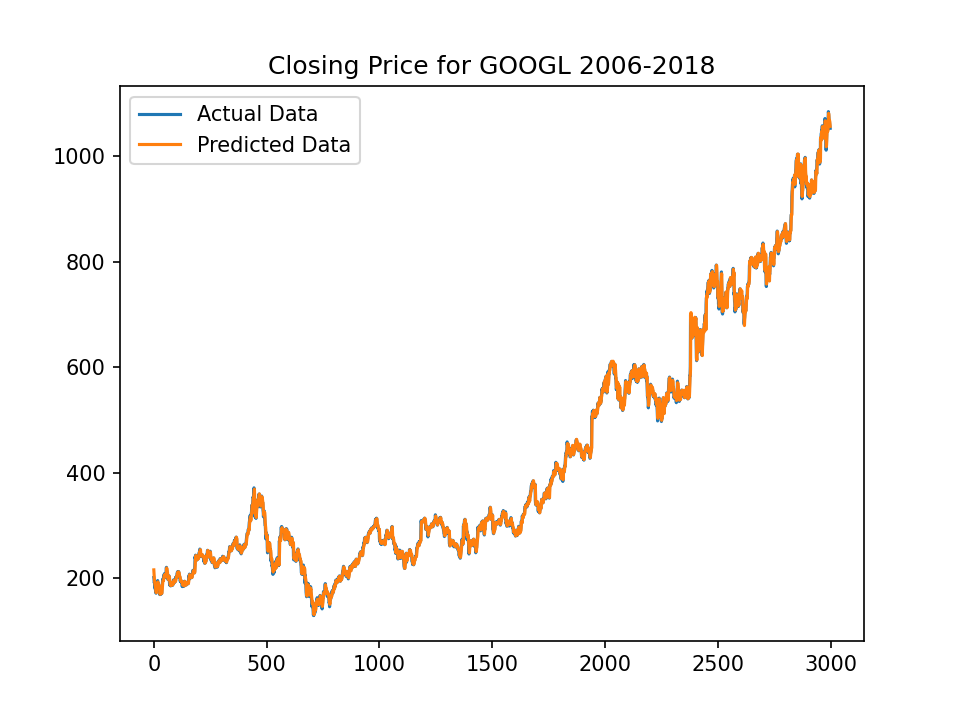

In [114]:
plt.figure()
plt.plot(stock.shift(periods=-20), label='Actual Data')
plt.plot(pred, label='Predicted Data')
plt.title("Closing Price for GOOGL 2006-2018")
plt.legend()
plt.show() 